In [1]:
import sys 
sys.path.append('../../')
from LlamaGym.llamagym import Agent

In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForCausalLM, LlamaForCausalLM, AutoTokenizer #, OPTForCausalLM, AutoModelForCausalLM
from transformers import StoppingCriteria, StoppingCriteriaList

from transformers import GenerationConfig
import os
import torch

def generate_response(
    prompt,
    model = None,
    tokenizer = None,
    stopping_criteria = None,
    device = 'cuda',
    **kwargs,
    ):

    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        **kwargs,
    )
    with torch.no_grad():
        
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            stopping_criteria=stopping_criteria,
            output_hidden_states= True,
            output_scores=True,
            #output_attentions=True,
        )
        s = generation_output.sequences[0]
    output = tokenizer.decode(s)

    #print(output)

    return output, generation_output
from trl import AutoModelForCausalLMWithValueHead
def load_model(model_name, load_in_8_bit=False, load_in_4_bit=False, value_head=True): 

    LOAD_8BIT = load_in_8_bit
    LOAD_4BIT = load_in_4_bit

    assert not(LOAD_4BIT and LOAD_8BIT), "Can't load 4bit and 8bit at the same"

    BASE_MODEL = model_name
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
    if value_head:
        model = AutoModelForCausalLMWithValueHead.from_pretrained(
                BASE_MODEL,
                load_in_8bit=LOAD_8BIT,
                load_in_4bit=LOAD_4BIT,
                torch_dtype=torch.float16,
                trust_remote_code = True,
            # device_map="auto",
            )
        
    else: 
        model = AutoModelForCausalLM.from_pretrained(
                BASE_MODEL,
                load_in_8bit=LOAD_8BIT,
                load_in_4bit=LOAD_4BIT,
                torch_dtype=torch.float16,
                trust_remote_code = True,
            # device_map="auto",
            )

    #model.cuda()
    if "openchat" in model.config._name_or_path:
        if value_head:
            model.pretrained_model.generation_config.pad_token_id = 0
        else:
            model.generation_config.pad_token_id = 0

    elif "Qwen" in model.config._name_or_path:
        
        if value_head:
            model.pretrained_model.generation_config.pad_token_id = 151643

        else:
            model.generation_config.pad_token_id = 151643


    elif "Phi-3" in model.config._name_or_path:
        #model.pretrained_model.generation_config.eos_token_id = 32007
        if value_head:
            tokenizer.eos_token_id = 32007
        
        else:
            model.generation_config.pad_token_id = 32007

    elif "Meta-Llama-3-8B-Instruct" in model.config._name_or_path:
        #model.pretrained_model.generation_config.eos_token_id = 32007
        if value_head:
            model.pretrained_model.generation_config.pad_token_id = tokenizer.eos_token_id
            
        else:
            model.generation_config.pad_token_id = 32007
        
        tokenizer.eos_token_id = 128009
        tokenizer.chat_template = """
{% set loop_messages = messages %}
{% for message in loop_messages %}
{% set content = '<|start_header_id|>' + message['role'] + '<|end_header_id|>'+ message['content'] | trim + '<|eot_id|>' %}
{% if loop.index0 == 0 %} {% set content = bos_token + content %} {% endif %}
{{ content }}
{% endfor %}
        """

    elif "phi-2" in model.config._name_or_path:
        tokenizer.chat_template = tokenizer.chat_template = "{% set loop_messages = messages %}{% for message in loop_messages %}{% set content = message['content']%}{% if loop.index0 == 0 %} {% set content = bos_token + content%}{% endif %}{{content+eos_token}}{%endfor %}"
    
    if not load_in_8_bit:
        model = model.cuda()
        
    return tokenizer, model 

In [3]:
#model_name =  "Nexusflow/Starling-LM-7B-beta"#"Qwen/Qwen1.5-14B"#" "h2oai/h2o-danube2-1.8b-base"#
model_name = "microsoft/Phi-3-mini-4k-instruct"# "openchat/openchat-3.5-0106"
models = ["microsoft/phi-2","microsoft/Phi-3-mini-4k-instruct", "meta-llama/Llama-2-7b-chat-hf", ]
#model_name = "microsoft/phi-2" #"meta-llama/Llama-2-7b-chat-hf" # "meta-llama/Meta-Llama-3-8B-Instruct" # "openchat/openchat-3.5-0106" #"microsoft/Phi-3-mini-4k-instruct"
#model_name = "openchat/openchat-3.5-0106"# "meta-llama/Meta-Llama-3-8B-Instruct"#"microsoft/phi-2"#"meta-llama/Meta-Llama-3-8B-Instruct" #"meta-llama/Meta-Llama-3-8B"# 
model_name ="meta-llama/Meta-Llama-3-8B-Instruct"#"meta-llama/Llama-2-7b-chat-hf"##
tokenizer, model = load_model(model_name, load_in_8_bit=True,value_head=False)#, load_in_4_bit=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Tokenization 

In [3]:
#prompt = "What is the colour of the sky?"
#generate_response(prompt, model=model, tokenizer=tokenizer)

In [33]:
tokenizer.encode("<|eot_id|>")

[128000, 128009]

In [31]:
model.config._name_or_path

'meta-llama/Meta-Llama-3-8B-Instruct'

In [5]:
tokenizer.encode("<pad>")

[128000, 8085, 329, 29]

In [8]:
tokenizer.decode([8085])

'<p'

In [1]:
#[word for word in tokenizer.vocab.keys() if "<|" in word]

### testing chat_template

In [ ]:
# def llm(self, messages: List[Dict[str, str]]) -> str:
prompt = self.tokenizer.apply_chat_template(
#         messages, tokenize=False, add_generation_prompt=True
#     )
#     inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
#     generate_ids = self.model.generate(
#         inputs=inputs.input_ids,
#         **{
#             key.split("/")[-1]: value
#             for key, value in self.generate_config_dict.items()
#         }
#     )
#     outputs = self.tokenizer.batch_decode(
#         generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
#     )
#     response = outputs[0].split("[/INST]")[-1].strip()

#     return response

# def act(self, observation):
#     message = self.format_observation(observation)
#     self.current_episode_messages += [{"role": "user", "content": message}]

#     response = self.llm(self.current_episode_messages)
#     try:
#         action = self.extract_action(response)
#     except Exception as e:
#         return None

#     self.current_episode_messages += [{"role": "assistant", "content": response}]
#     return action

In [48]:
tokenizer.eos_token

'<|endoftext|>'

In [59]:
tokenizer.bos_token

'<|endoftext|>'

In [23]:
-len(tokenizer.eos_token)

-7

In [17]:
model.pretrained_model.generation_config

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 32007,
  "pad_token_id": 32000
}

In [42]:
# tokenizer.chat_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

# {{ system_prompt }}<|eot_id|><|start_header_id|>user<|end_header_id|>

# {{ user_msg_1 }}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

# {{ model_answer_1 }}<|eot_id|>"""
# tokenizer.chat_template = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>{{@root.preprompt}}<|eot_id|>{{#each messages}}{{#ifUser}}<|start_header_id|>user<|end_header_id|>{{content}}<|eot_id|>{{/ifUser}}{{#ifAssistant}}<|start_header_id|>assistant<|end_header_id|>{{content}}<|eot_id|>{{/ifAssistant}}{{/each}}<|start_header_id|>assistant<|end_header_id|>"

# tokenizer.chat_template = """{% set loop_messages = messages %}
# {% for message in loop_messages %}
# {% set content = '<|start_header_id|>' + message['role'] + '<|end_header_id|>'+ message['content'] | trim + '<|eot_id|>' %}
# {% if loop.index0 == 0 %} {% set content = bos_token + content %} {% endif %}
# {{ content }}
# {% endfor %}
# """
# #{{ '<|start_header_id|>assistant<|end_header_id|>' }}


In [4]:
print(tokenizer.chat_template)

{{ bos_token }}{% for message in messages %}{% if (message['role'] == 'user') %}{{'<|user|>' + '
' + message['content'] + '<|end|>' + '
' + '<|assistant|>' + '
'}}{% elif (message['role'] == 'assistant') %}{{message['content'] + '<|end|>' + '
'}}{% endif %}{% endfor %}


In [17]:
pattern_1 ="""
Time Step Channel A Channel B Channel C Channel D
1| 1 1 0 0
2| 1 1 0 0
3| 0 0 1 1
4| 0 0 1 1
5| 1 1 0 0"""
answer_1 = """{"next_row": "1 1 0 0"}"""
history = [{"role": "user", "content": pattern_1},
            {"role": "assistant", "content": answer_1}]
message = "hi"
history.append({"role": "user", "content": message})
history.append({"role": "assistant", "content": '{"next_row": "'})
               
prompt = tokenizer.apply_chat_template(
            history, tokenize=False, add_generation_prompt=False, add_special_tokens=False)
prompt = prompt.strip()
print(prompt)
print("________")
prompt = prompt[:-len(tokenizer.eos_token)]#.replace(tokenizer.eos_token,"")
print(prompt)
print("________")
prompt = prompt[len(tokenizer.bos_token):]
prompt = prompt.strip()
print(prompt)


<|begin_of_text|><|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1| 1 1 0 0
2| 1 1 0 0
3| 0 0 1 1
4| 0 0 1 1
5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_header_id|>user<|end_header_id|>hi<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "<|eot_id|>
________
<|begin_of_text|><|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1| 1 1 0 0
2| 1 1 0 0
3| 0 0 1 1
4| 0 0 1 1
5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_header_id|>user<|end_header_id|>hi<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "
________
<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1| 1 1 0 0
2| 1 1 0 0
3| 0 0 1 1
4| 0 0 1 1
5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_he

In [9]:
prompt = """Time Step Channel A Channel B Channel C Channel D
1| 1 1 0 0
2| 1 1 0 0
3| 0 0 1 1
4| 0 0 1 1
5| 1 1 0 0<|im_end|>
<|im_start|>assistant
{"next_row": "1 1 0 0"}<|im_end|>
<|im_start|>user
hi<|im_end|>
<|im_start|>assistant
{"next_ro"""
tokenizer.decode(tokenizer(prompt).input_ids)

'<|begin_of_text|>Time Step Channel A Channel B Channel C Channel D\n1| 1 1 0 0\n2| 1 1 0 0\n3| 0 0 1 1\n4| 0 0 1 1\n5| 1 1 0 0<|im_end|>\n<|im_start|>assistant\n{"next_row": "1 1 0 0"}<|im_end|>\n<|im_start|>user\nhi<|im_end|>\n<|im_start|>assistant\n{"next_ro'

In [43]:
tokenizer.bos_token#os.all_special_tokens

'<s>'

In [14]:
# pattern_1 ="""
# Time Step Channel A Channel B Channel C Channel D
# 1| 1 1 0 0
# 2| 1 1 0 0
# 3| 0 0 1 1
# 4| 0 0 1 1
# 5| 1 1 0 0 \n"""
# answer_1 = """{"next_row": "1 1 0 0"}\n"""
# current_episode_messages = [{"role": "user", "content": pattern_1},
#         {"role": "assistant", "content": answer_1}]

# current_episode_messages.append({"role": "user", "content": message})
# current_episode_messages.append({"role": "assistant", "content": '{"next_row": '})
            
# prompt = tokenizer.apply_chat_template(
#             current_episode_messages, tokenize=False, add_generation_prompt=False)

# prompt = prompt.replace(tokenizer.eos_token, "")
# print(prompt)

### testing outlines 

In [4]:
%load_ext autoreload
%autoreload 2
import outlines
model_out = outlines.models.Transformers(model, tokenizer)
#model = outlines.models.transformers("meta-llama/Llama-2-7b-chat-hf")
#model = outlines.models.transformers("meta-llama/Meta-Llama-3-8B-Instruct")

In [9]:

prompt = "[INST] What is the IP address of the Google DNS servers? [/INST]"

generator = outlines.generate.text(model_out)
unstructured = generator(prompt, max_tokens=30)

In [10]:
print(unstructured)

 Google provides two DNS servers that you can use for resolving domain names to IP addresses:

IP address of Google DNS server 1:


In [13]:
tokenizer.decode([    1,   518, 25580, 29962,  1724,   338,   278,  5641,  3211,   310,
           278,  5087, 16332, 12424, 29973,   518, 29914, 25580, 29962])

'<s> [INST] What is the IP address of the Google DNS servers? [/INST]'

In [15]:
tokenizer.decode([    1,   518, 25580, 29962,  1724,   338,   278,  5641,  3211,   310,
           278,  5087, 16332, 12424, 29973,   518, 29914, 25580, 29962,  3487,
            13, 10967,    13,  3487,    13,  3487])

'<s> [INST] What is the IP address of the Google DNS servers? [/INST]md\nBook\nmd\nmd'

In [14]:


generator = outlines.generate.regex(
    model_out,
    r"((25[0-5]|2[0-4]\d|[01]?\d\d?)\.){3}(25[0-5]|2[0-4]\d|[01]?\d\d?)",
)
structured = generator(prompt, max_tokens=30)

print(unstructured)
# What is the IP address of the Google DNS servers?
#
# Passive DNS servers are at DNS servers that are private.
# In other words, both IP servers are private. The database
# does not contain Chelsea Manning

print(structured)
# What is the IP address of the Google DNS servers?
# 2.2.6.1

tensor([[    1,   518, 25580, 29962,  1724,   338,   278,  5641,  3211,   310,
           278,  5087, 16332, 12424, 29973,   518, 29914, 25580, 29962,  3487,
            13, 10967,    13,  3487,    13,  3487]], device='cuda:0')
 Google provides two DNS servers that you can use for resolving domain names to IP addresses:

IP address of Google DNS server 1:
md
Book
md
md


In [7]:
import outlines
    #r"((25[0-5]|2[0-4]\d|[01]?\d\d?)\.){3}(25[0-5]|2[0-4]\d|[01]?\d\d?)",
sampler = outlines.samplers.GreedySampler()
model_out = outlines.models.Transformers(model, tokenizer)

generator = outlines.generate.regex(
    model_out,
    regex_str = r"([0-1]\|[0-1]\|[0-1]\|[0-1])",
)
structured = generator(prompt, max_tokens=30)


In [8]:
structured

'1|1|1|1'

In [9]:
## testing outlines 

import outlines

model_out = outlines.models.Transformers(model, tokenizer)

prompt = '''<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|1|0|0|0|
|2|0|1|0|0|
|3|0|0|1|0|
|4|0|0|0|1|
|5|1|0|0|0|
|6|0|1|0|0|
|7|0|0|1|0|
|8|0|0|0|1|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|9|'''

#prompt = "Hi"

# generator = outlines.generate.text(model)
# unstructured = generator(prompt, max_tokens=30)



structured = generator(prompt, max_tokens=30)

#print(unstructured)
# What is the IP address of the Google DNS servers?
#
# Passive DNS servers are at DNS servers that are private.
# In other words, both IP servers are private. The database
# does not contain Chelsea Manning

print(structured)
# What is the IP address of the Google DNS servers?
# 2.2.6.1

1|0|0|0


In [11]:
number_sequence = "1|0|0|0"
number_array = number_sequence.split("|")
number_array

['1', '0', '0', '0']

### agent 1 

In [4]:
import gym
from abc import ABC, abstractmethod
import torch
import re 

class ReinforcementAgent(Agent):
    def __init__(self, model, tokenizer, device, generate_config_dict=None, ppo_config_dict=None):
        super().__init__(model, tokenizer, device, generate_config_dict, ppo_config_dict)
        self.stopping_criteria = None 
    def get_system_prompt(self) -> str:
        # Starting system prompt or any initialization text if needed
        return "Initialize system state."

    def format_observation(self, observations) -> str:
        interference_map = "\nTime Step Channel A Channel B Channel C Channel D\n"
        for i, state in enumerate(observations):
            interference_map += f"{i+1}\t{state[0]}\t{state[1]}\t{state[2]}\t{state[3]}\n"
        #interference_map += "\n"
        return interference_map

    def extract_action(self, response: str) -> gym.core.ActType:
        # Example pattern match and action extraction logic
        pattern = r'\{"next_row": "(.*?)"\}'
        match = re.search(pattern, response)
        if match:
            number_sequence = match.group(1)
            print("Prediction : ", number_sequence)
            number_array = number_sequence.split()
            number_array_int = [int(num) for num in number_array]
            action = number_array_int.index(0)  # finding the first zero as an example action
            return action
        raise ValueError("Failed to extract action from response.")
    
    def parse_output(self, prompt, output):

        output =output[len(self.tokenizer.decode(self.tokenizer.encode(prompt))):]
        return output


    def llm(self,
        prompt,
        ):

        inputs = self.tokenizer(prompt, return_tensors="pt")
        input_ids = inputs["input_ids"].to(self.device)
        generation_config = GenerationConfig(
             **self.generate_config_dict,
         )    
        with torch.no_grad():
            
            generation_output = self.model.generate(
                input_ids=input_ids,
                return_dict_in_generate=True,
                generation_config=generation_config,
                #stopping_criteria=self.stopping_criteria,
                #output_hidden_states= True,
                #output_scores=True,
                #output_attentions=True,
                ## Bug generation configuratio args need to be added as keyword arguments
                #**self.generate_config_dict
            )
            s = generation_output.sequences[0]
        output = self.tokenizer.decode(s)

        #print(output)

        return output
    
    def create_prompt(self, message):#, user_message="GPT4 Correct User: ", system_message= "GPT4 Correct Assistant:", end_message= "<|end_of_turn|>"): 
        
        pattern_1 ="""
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0"""
        answer_1 = """{"next_row": "1 1 0 0"}"""
        self.current_episode_messages = [{"role": "user", "content": pattern_1},
                {"role": "assistant", "content": answer_1}]
        
        self.current_episode_messages.append({"role": "user", "content": message})
        self.current_episode_messages.append({"role": "assistant", "content": '{"next_row": "'})
                    
        prompt = self.tokenizer.apply_chat_template(
                    self.current_episode_messages, tokenize=False, add_generation_prompt=False, add_special_tokens=False)

        #print(prompt)
        prompt = prompt.strip()
        prompt = prompt[:-len(tokenizer.eos_token)]##prompt.replace(self.tokenizer.eos_token, "")
        #print(prompt)
        prompt = prompt[len(tokenizer.bos_token):]
        #print(prompt)
        return prompt

    def act(self, observations):
        message = self.format_observation(observations)
        #self.current_episode_messages += [{"role": "user", "content": message}]
        prompt = self.create_prompt(message)
        print(prompt)
        response = self.llm(prompt)
        response = self.parse_output(prompt, response)
        response = '{"next_row": "'+ response
        print(response)
        try:
            action = self.extract_action(response)
        except Exception as e:
            print("Exception catched ", e)
            return None

        #self.current_episode_messages += [{"role": "assistant", "content": response}]
        return action

# Example usage
# Define `model`, `tokenizer`, `device` variables appropriately.
# Instantiate the agent and use it in a simulation or training loop.
device = "cuda"

MAX_NEW_TOKENS=20
generation_args = {"max_new_tokens":MAX_NEW_TOKENS,
            "do_sample": True, 
            "num_beams" : 1, 
            "num_return_sequences" : 1, 
            "temperature": 0.01,# 0.8, 
            "top_p": 0.95,
            #"min_new_tokens": 256, 
            #"no_repeat_ngram_size": 12, 
            #"begin_suppress_tokens": [2], 
            }

agent = ReinforcementAgent(model, tokenizer, device, generate_config_dict=generation_args)

### agent 2

In [11]:
import gym
from abc import ABC, abstractmethod
import torch
import re 
import outlines


class ReinforcementAgent(Agent):
    def __init__(self, model, tokenizer, device, generate_config_dict=None, ppo_config_dict=None):
        super().__init__(model, tokenizer, device, generate_config_dict, ppo_config_dict)
        self.stopping_criteria = None 
        self.max_messages = 6

    def add_message(self, message):
        self.current_episode_messages.append(message)
        # Check if the length exceeds the max_messages and remove the oldest two messages if it does
        if len(self.current_episode_messages) > self.max_messages:
            self.current_episode_messages.pop(0)  # Remove the oldest message
            self.current_episode_messages.pop(0)  # Remove the second oldest message
    
    def get_system_prompt(self) -> str:
        # Starting system prompt or any initialization text if needed
        return "Initialize system state."

    

    def format_observation(self, observations) -> str:
        interference_map = """| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|\n"""

        # | Time Step | Channel A | Channel B | Channel C | Channel D |
        # |-----------|-----------|-----------|-----------|-----------|
        # |1|1|0|0|0|
        # |2|0|1|0|0|
        # |3|0|0|1|0|
        # |4|0|0|0|1|
        # |5|1|0|0|0|
        # |6|0|1|0|0|
        # |7|0|0|1|0|
        # |8|0|0|0|1|
        # |9|1|0|0|0|
        # |10|0|1|0|0|
        # Continue<|eot_id|>
        # <|start_header_id|>assistant<|end_header_id|>
        # Here is the continuation of the time step table:

        # | Time Step | Channel A | Channel B | Channel C | Channel D |
        # |-----------|-----------|-----------|-----------|-----------|

        for i, state in enumerate(observations):
            interference_map += f"|{i+1}|{state[0]}|{state[1]}|{state[2]}|{state[3]}|\n"
        #interference_map += "\n"
        return interference_map
    
    def create_prompt(self, message):#, user_message="GPT4 Correct User: ", system_message= "GPT4 Correct Assistant:", end_message= "<|end_of_turn|>"): 
        
        # pattern_1 ="""
        # Time Step Channel A Channel B Channel C Channel D
        # 1| 1 1 0 0
        # 2| 1 1 0 0
        # 3| 0 0 1 1
        # 4| 0 0 1 1
        # 5| 1 1 0 0"""
        # answer_1 = """{"next_row": "1 1 0 0"}"""
        # self.current_episode_messages = [{"role": "user", "content": pattern_1},
        #         {"role": "assistant", "content": answer_1}]
        
        #self.current_episode_messages.append({"role": "assistant", "content": '{"next_row": "'})

        self.current_episode_messages = [{"role": "user", "content": message}]

        pattern = r"^\|\s*(\d+)\s*\|"
        matches = re.findall(pattern, message, re.MULTILINE)
        last_time_step = int(matches[-1])
        started_assistant_message = f"""Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|{last_time_step+1}|"""
        
        self.current_episode_messages.append({"role": "assistant", "content": started_assistant_message})
        

        prompt = self.tokenizer.apply_chat_template(
                    self.current_episode_messages, tokenize=False, add_generation_prompt=False, add_special_tokens=False)

        #print(prompt)
        prompt = prompt.strip()
        prompt = prompt[:-len(tokenizer.eos_token)]##prompt.replace(self.tokenizer.eos_token, "")
        #print(prompt)
        prompt = prompt[len(tokenizer.bos_token):]
        #print(prompt)
        return prompt

    def extract_action(self, response: str) -> gym.core.ActType:
        # Example pattern match and action extraction logic
        #pattern = r'\{"next_row": "(.*?)"\}'
        #match = re.search(pattern, response)
        #if match:
        number_sequence = response
        print("Prediction : ", number_sequence)
        number_array = number_sequence.split("|")
        number_array_int = [int(num) for num in number_array]
        action = number_array_int.index(0)  # finding the first zero as an example action
        return action
        #raise ValueError("Failed to extract action from response.")
    
    def parse_output(self, prompt, output):

        output =output[len(self.tokenizer.decode(self.tokenizer.encode(prompt))):]
        return output


    def llm(self,
        prompt,
        ):

        # inputs = self.tokenizer(prompt, return_tensors="pt")
        # input_ids = inputs["input_ids"].to(self.device)
        # generation_config = GenerationConfig(
        #      **self.generate_config_dict,
        #  )    
        # with torch.no_grad():
            
        #     generation_output = self.model.generate(
        #         input_ids=input_ids,
        #         return_dict_in_generate=True,
        #         generation_config=generation_config,
        #         #stopping_criteria=self.stopping_criteria,
        #         #output_hidden_states= True,
        #         #output_scores=True,
        #         #output_attentions=True,
        #         ## Bug generation configuratio args need to be added as keyword arguments
        #         #**self.generate_config_dict
        #     )
        #     s = generation_output.sequences[0]
        # output = self.tokenizer.decode(s)

        #print(output)

        model_out = outlines.models.Transformers(self.model, self.tokenizer)


        #[1-9]|[1-9][0-9]\|
        generator = outlines.generate.regex(
            model_out,
            r"([0-1]\|[0-1]\|[0-1]\|[0-1])")#,
           
           #r"([1-9]|[1-9][0-9])(\|([1-9]|[1-9][0-9]))(\|([1-9]|[1-9][0-9]))(\|([1-9]|[1-9][0-9]))")
        output = generator(prompt, max_tokens=30)
        return output

    def act(self, observations):
        message = self.format_observation(observations)
        #self.current_episode_messages += [{"role": "user", "content": message}]
        prompt = self.create_prompt(message)
        print(prompt)
        response = self.llm(prompt)
        #response = self.parse_output(prompt, response)
        #response = '{"next_row": "'+ response
        print(response)
        try:
            action = self.extract_action(response)
        except Exception as e:
            print("Exception catched ", e)
            return None

        #self.current_episode_messages += [{"role": "assistant", "content": response}]
        return action

# Example usage
# Define `model`, `tokenizer`, `device` variables appropriately.
# Instantiate the agent and use it in a simulation or training loop.
device = "cuda"

MAX_NEW_TOKENS=20
generation_args = {"max_new_tokens":MAX_NEW_TOKENS,
            "do_sample": True, 
            "num_beams" : 1, 
            "num_return_sequences" : 1, 
            "temperature": 0.01,# 0.8, 
            "top_p": 0.95,
            #"min_new_tokens": 256, 
            #"no_repeat_ngram_size": 12, 
            #"begin_suppress_tokens": [2], 
            }

agent = ReinforcementAgent(model, tokenizer, device, generate_config_dict=generation_args)

In [16]:
import re

message = """| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|1|0|0|0|
"""
|2|0|1|0|0|
|3|0|0|1|0|
|4|0|0|0|1|
|5|1|0|0|0|
|6|0|1|0|0|
|7|0|0|1|0|
|8|0|0|0|1|
|9|1|0|0|0|
|10|0|1|0|0|
pattern = r"^\|\s*(\d+)\s*\|"
matches = re.findall(pattern, message, re.MULTILINE)

# for match in matches:
#     print(match.group(1))
matches[-1]
matches


['1']

In [21]:
import pandas as pd 
results_all = pd.read_json("llama3_greedy_sampler_agent_noise_test.json")

observations = results_all.iloc[-1].states_history[0:16]

In [13]:
import numpy as np 

observations = [[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
#[0, 0, 1, 0],
#[0, 0, 0, 1],
#[1, 0, 0, 0]
]

observations = [[40, 30, 19, 25], 
                [20, 39, 33, 13], 
                [17, 21, 52, 28], 
                [28, 23, 13, 36], 
                [45, 26, 22, 27], 
                [15, 44, 20, 28], 
                [30, 27, 52, 33], 
                [29, 29, 14, 50], 
                [43, 13, 18, 30], 
                [18, 50, 22, 25], 
                [26, 23, 53, 20], 
                [30, 19, 31, 34], 
                [43, 19, 14, 17], 
                [15, 52, 28, 23]]

# observations = results_all.iloc[-1].states_history[0:16]

# # Find min and max for each column
# mins = np.min(observations, axis=0)
# maxs = np.max(observations, axis=0)

# # Scale each column
# scaled_observations = (observations - mins) / (maxs - mins) * 10
# scaled_observations = np.round(scaled_observations).astype(int)
#output = agent.format_observation(scaled_observations)

output = agent.format_observation(observations)


prompt = agent.create_prompt(output)
print(prompt)
print(agent.llm(prompt))
#output = agent.llm(prompt)

#parsed_output = agent.parse_output(prompt, output)

#print(parsed_output)

[INST] | Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|1|0|0|0|
|2|0|1|0|0|
|3|0|0|1|0|
|4|0|0|0|1|
|5|1|0|0|0|
|6|0|1|0|0| [/INST] Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|7| 
XXX


In [14]:
model_out = outlines.models.Transformers(model, tokenizer)


#[1-9]|[1-9][0-9]\|
generator = outlines.generate.regex(
    model_out,
    r"([0-1]\|[0-1]\|[0-1]\|[0-1])")#,
    
    #r"([1-9]|[1-9][0-9])(\|([1-9]|[1-9][0-9]))(\|([1-9]|[1-9][0-9]))(\|([1-9]|[1-9][0-9]))")
output = generator(prompt, max_tokens=30)

In [19]:
generator = outlines.generate.regex(
    model_out,
    r"((25[0-5]|2[0-4]\d|[01]?\d\d?)\.){3}(25[0-5]|2[0-4]\d|[01]?\d\d?)",
)
structured = generator(prompt, max_tokens=30)

print(structured)

leans
back
gy
sh


In [17]:
tokenizer

LlamaTokenizerFast(name_or_path='meta-llama/Llama-2-7b-chat-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [16]:
#print(output)

XX


In [9]:
MAX_NEW_TOKENS=30
generation_args = {"max_new_tokens":MAX_NEW_TOKENS,
            "do_sample": True, 
            "num_beams" : 1, 
            "num_return_sequences" : 1, 
            "temperature": 0.01,# 0.8, 
            "top_p": 0.95,
            "min_new_tokens": 256, 
            #"no_repeat_ngram_size": 12, 
            #"begin_suppress_tokens": [128009], 
            }

output, sequences = generate_response(prompt, model, tokenizer, device="cuda", stopping_criteria=None, **generation_args)
print(output)

/home/paul/miniconda3/envs/llmagent/lib/python3.12/site-packages/transformers/generation/utils.py:1164: UserWarning: Unfeasible length constraints: `min_new_tokens` (256), when added to the prompt length (164), is larger than the maximum possible length (194). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length. Note that `max_length` is set to 194, its default value.
  warnings.warn(


<s> [INST] | Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|1|0|0|0|
|2|0|1|0|0|
|3|0|0|1|0|
|4|0|0|0|1|
|5|1|0|0|0|
|6|0|1|0|0| [/INST] Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|7| 0 | 0 | 1 | 0 |
|8| 0 | 1 | 0 | 1 |
|9


In [8]:
agent.llm(prompt)

'uelX overX thanXCan'

In [ ]:
prompt = """<|begin_of_text|><|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|41|22|22|26|
|2|24|42|25|23|
|3|23|21|41|23|
|4|22|22|24|44|
|5|42|22|21|21|
|6|22|46|25|24|
|7|24|21|42|22|
|8|22|20|20|44|
|9|42|25|25|21|
|10|21|46|26|22|
|11|22|26|45|24|
|12|20|26|24|43|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>PATTERN: 1-2-3-4

So the probable next row in the table is:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|"""

### agent_2 noise 

In [4]:
import gym
from abc import ABC, abstractmethod
import torch
import re 
import outlines


class ReinforcementAgent(Agent):
    def __init__(self, model, tokenizer, device, generate_config_dict=None, ppo_config_dict=None):
        super().__init__(model, tokenizer, device, generate_config_dict, ppo_config_dict)
        self.stopping_criteria = None 
        self.current_episode_messages = []
        self.max_messages = 6

    def add_message(self, message):
        self.current_episode_messages.append(message)
        # Ensure the length of current_episode_messages does not exceed max_messages
        while len(self.current_episode_messages) > self.max_messages:
            self.current_episode_messages.pop(0)  # Remove the oldest message until the length constraint is met

    def get_system_prompt(self) -> str:
        # Starting system prompt or any initialization text if needed
        return "Initialize system state."

    def format_observation(self, observations) -> str:
        interference_map = """| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|\n"""

        for i, state in enumerate(observations):
            interference_map += f"|{i+1}|{state[0]}|{state[1]}|{state[2]}|{state[3]}|\n"
        #interference_map += "\n"
        return interference_map
    
    def create_prompt(self, message):

        self.current_episode_messages.append({"role": "user", "content": message})

        pattern = r"^\|\s*(\d+)\s*\|"
        matches = re.findall(pattern, message, re.MULTILINE)
        last_time_step = int(matches[-1])
        started_assistant_message = f"""Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|{last_time_step+1}|"""
        
        #self.current_episode_messages.append({"role": "assistant", "content": started_assistant_message})
        
        self.add_message({"role": "assistant", "content": started_assistant_message})

        prompt = self.tokenizer.apply_chat_template(
                    self.current_episode_messages, tokenize=False, add_generation_prompt=False, add_special_tokens=False)

        #print(prompt)
        prompt = prompt.strip()
        prompt = prompt[:-len(tokenizer.eos_token)]##prompt.replace(self.tokenizer.eos_token, "")
        #print(prompt)
        prompt = prompt[len(tokenizer.bos_token):]
        #print(prompt)
        return prompt

    def extract_action(self, response: str) -> gym.core.ActType:
        
        number_sequence = response
        print("Prediction : ", number_sequence)
        number_array = number_sequence.split("|")
        number_array_int = [int(num) for num in number_array]
        action = number_array_int.index(0)  # finding the first zero as an example action
        return action
        #raise ValueError("Failed to extract action from response.")
    
    def parse_output(self, prompt, output):

        output =output[len(self.tokenizer.decode(self.tokenizer.encode(prompt))):]
        return output

    def llm(self,
        prompt,
        ):

        # inputs = self.tokenizer(prompt, return_tensors="pt")
        # input_ids = inputs["input_ids"].to(self.device)
        # generation_config = GenerationConfig(
        #      **self.generate_config_dict,
        #  )    
        # with torch.no_grad():
            
        #     generation_output = self.model.generate(
        #         input_ids=input_ids,
        #         return_dict_in_generate=True,
        #         generation_config=generation_config,
        #         #stopping_criteria=self.stopping_criteria,
        #         #output_hidden_states= True,
        #         #output_scores=True,
        #         #output_attentions=True,
        #         ## Bug generation configuratio args need to be added as keyword arguments
        #         #**self.generate_config_dict
        #     )
        #     s = generation_output.sequences[0]
        # output = self.tokenizer.decode(s)

        #print(output)

        model_out = outlines.models.Transformers(self.model, self.tokenizer)


        #[1-9]|[1-9][0-9]\| #
        #    r"([0-1]\|[0-1]\|[0-1]\|[0-1])")#,
        generator = outlines.generate.regex(
            model_out,
            r"([1-9]|[1-9][0-9])(\|([1-9]|[1-9][0-9]))(\|([1-9]|[1-9][0-9]))(\|([1-9]|[1-9][0-9]))")
        output = generator(prompt, max_tokens=30)
        return output

    def act(self, observations):
        message = self.format_observation(observations)
        #self.current_episode_messages += [{"role": "user", "content": message}]
        prompt = self.create_prompt(message)
        print(prompt)
        response = self.llm(prompt)
        #response = self.parse_output(prompt, response)
        #response = '{"next_row": "'+ response
        print(response)
        try:
            action = self.extract_action(response)
        except Exception as e:
            print("Exception catched ", e)
            return None

        #self.current_episode_messages += [{"role": "assistant", "content": response}]
        return action

# Example usage
# Define `model`, `tokenizer`, `device` variables appropriately.
# Instantiate the agent and use it in a simulation or training loop.
device = "cuda"

MAX_NEW_TOKENS=20
generation_args = {"max_new_tokens":MAX_NEW_TOKENS,
            "do_sample": True, 
            "num_beams" : 1, 
            "num_return_sequences" : 1, 
            "temperature": 0.01,# 0.8, 
            "top_p": 0.95,
            #"min_new_tokens": 256, 
            #"no_repeat_ngram_size": 12, 
            #"begin_suppress_tokens": [2], 
            }

agent = ReinforcementAgent(model, tokenizer, device, generate_config_dict=generation_args)

In [29]:
import pandas as pd 
results_all = pd.read_json("./llama3_greedy_sampler_agent_noise_test_fixed.json")

observations = results_all.iloc[-1].states_history[0:16]

In [30]:
import numpy as np 

observations = [[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
#[0, 0, 1, 0],
#[0, 0, 0, 1],
#[1, 0, 0, 0]
]

observations = [[40, 30, 19, 25], 
                [20, 39, 33, 13], 
                [17, 21, 52, 28], 
                [28, 23, 13, 36], 
                [45, 26, 22, 27], 
                [15, 44, 20, 28], 
                [30, 27, 52, 33], 
                [29, 29, 14, 50], 
                [43, 13, 18, 30], 
                [18, 50, 22, 25], 
                [26, 23, 53, 20], 
                [30, 19, 31, 34], 
                [43, 19, 14, 17], 
                [15, 52, 28, 23]]

observations = results_all.iloc[-1].states_history[0:16]

# # Find min and max for each column
# mins = np.min(observations, axis=0)
# maxs = np.max(observations, axis=0)

# # Scale each column
# scaled_observations = (observations - mins) / (maxs - mins) * 10
# scaled_observations = np.round(scaled_observations).astype(int)
#output = agent.format_observation(scaled_observations)

output = agent.format_observation(observations)


prompt = agent.create_prompt(output)
print(prompt)
#print(agent.llm(prompt))
#output = agent.llm(prompt)

#parsed_output = agent.parse_output(prompt, output)

#print(parsed_output)

<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|
|9|41|21|20|26|
|10|24|46|24|24|
|11|23|21|40|22|
|12|21|25|26|45|
|13|40|26|25|24|
|14|23|46|23|22|
|15|25|26|45|21|
|16|24|20|23|42|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|17|


In [ ]:
"""<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|40|30|19|25|
|2|20|39|33|13|
|3|17|21|52|28|
|4|28|23|13|36|
|5|45|26|22|27|
|6|15|44|20|28|
|7|30|27|52|33|
|8|29|29|14|50|
|9|43|13|18|30|
|10|18|50|22|25|
|11|26|23|53|20|
|12|30|19|31|34|
|13|43|19|14|17|
|14|15|52|28|23|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:
"""

In [51]:
prompt = """<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|9|43|13|18|30|<|eot_id|>

<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|
|9|43|13|18|30|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|10|18|50|22|25|<|eot_id|>

<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|
|9|43|13|18|30|
|10|18|50|22|25|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|11|"""


conversation = [
    {
        "role": "user",
        "content": """Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|"""
    },
    {
        "role": "assistant",
        "content": """Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|9|43|13|18|30|"""
    },
    {
        "role": "user",
        "content": """Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|
|9|43|13|18|30|"""
    },
    {
        "role": "assistant",
        "content": """Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|10|18|50|22|25|"""
    },
#     {
#         "role": "user",
#         "message": """Time Step | Channel A | Channel B | Channel C | Channel D |
# |-----------|-----------|-----------|-----------|-----------|
# |1|46|26|25|20|
# |2|21|45|21|25|
# |3|23|23|42|24|
# |4|26|20|26|45|
# |5|41|24|24|25|
# |6|20|42|22|26|
# |7|21|21|42|22|
# |8|20|23|25|43|
# |9|43|13|18|30|
# |10|18|50|22|25|"""
#     },
#     {
#         "role": "assistant",
#         "message": """Here is the continuation of the time step table:

# | Time Step | Channel A | Channel B | Channel C | Channel D |
# |-----------|-----------|-----------|-----------|-----------|
# |11|"""
#     }
]


In [ ]:
def add_to_history(observations, ground_truth): 
    
    ground_truth_str = f"{str(num)}|".join([num for num in ground_truth])
    addition = f"""Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
{len(observations)}|{addition}"""

    return addition

In [52]:
observations

[[46, 26, 25, 20],
 [21, 45, 21, 25],
 [23, 23, 42, 24],
 [26, 20, 26, 45],
 [41, 24, 24, 25],
 [20, 42, 22, 26],
 [21, 21, 42, 22],
 [20, 23, 25, 43],
 [41, 21, 20, 26],
 [24, 46, 24, 24],
 [23, 21, 40, 22],
 [21, 25, 26, 45],
 [40, 26, 25, 24],
 [23, 46, 23, 22],
 [25, 26, 45, 21],
 [24, 20, 23, 42]]

In [54]:
for message in conversation:
    
    agent.current_episode_messages.append(message)

    


In [49]:
#agent.current_episode_messages

In [55]:
output = agent.format_observation(observations)


prompt = agent.create_prompt(output)

print(prompt)

<|start_header_id|>user<|end_header_id|>Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|9|43|13|18|30|<|eot_id|>
<|start_header_id|>user<|end_header_id|>Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|
|9|43|13|18|30|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channe

In [57]:
output = agent.llm(prompt)

tensor([[128000, 128006,    882, 128007,   1489,  15166,    765,  13740,    362,
            765,  13740,    426,    765,  13740,    356,    765,  13740,    423,
           9432,     91,  18580,     91,  18580,     91,  18580,     91,  18580,
             91,  18580,   7511,     91,     16,     91,   2790,     91,   1627,
             91,    914,     91,    508,   7511,     91,     17,     91,   1691,
             91,   1774,     91,   1691,     91,    914,   7511,     91,     18,
             91,   1419,     91,   1419,     91,   2983,     91,   1187,   7511,
             91,     19,     91,   1627,     91,    508,     91,   1627,     91,
           1774,   7511,     91,     20,     91,   3174,     91,   1187,     91,
           1187,     91,    914,   7511,     91,     21,     91,    508,     91,
           2983,     91,   1313,     91,   1627,   7511,     91,     22,     91,
           1691,     91,   1691,     91,   2983,     91,   1313,   7511,     91,
             23,     91,    

'41|24|24|25'

In [59]:
tokenizer.decode(output[0])

TypeError: argument 'ids': Can't extract `str` to `Vec`

In [20]:
prompt = """<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|9|43|13|18|30|<|eot_id|>

<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|
|9|43|13|18|30|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|10|18|50|22|25|<|eot_id|>

<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|
|9|43|13|18|30|
|10|18|50|22|25|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|11|"""

generation_args = {'max_new_tokens': 124,
 'do_sample': True,
 'num_beams': 1,
 'num_return_sequences': 1,
 'temperature': 0.01,
 'top_p': 0.95}
output, sequences = generate_response(prompt, model, tokenizer, device="cuda", stopping_criteria=None, **generation_args)



In [22]:
print(output)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|9|43|13|18|30|<|eot_id|>

<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|26|25|20|
|2|21|45|21|25|
|3|23|23|42|24|
|4|26|20|26|45|
|5|41|24|24|25|
|6|20|42|22|26|
|7|21|21|42|22|
|8|20|23|25|43|
|9|43|13|18|30|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel 

### agent_3

In [6]:
import gym
from abc import ABC, abstractmethod
import torch
import re 
import outlines
import numpy as np 
class ReinforcementAgent(Agent):
    def __init__(self, model, tokenizer, device, generate_config_dict=None, ppo_config_dict=None):
        super().__init__(model, tokenizer, device, generate_config_dict, ppo_config_dict)
        self.stopping_criteria = None 
    def get_system_prompt(self) -> str:
        # Starting system prompt or any initialization text if needed
        return "Initialize system state."

    def format_observation(self, observations) -> str:
        interference_map = """OBSERVATIONS:| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|\n"""

        # | Time Step | Channel A | Channel B | Channel C | Channel D |
        # |-----------|-----------|-----------|-----------|-----------|
        # |1|1|0|0|0|
        # |2|0|1|0|0|
        # |3|0|0|1|0|
        # |4|0|0|0|1|
        # |5|1|0|0|0|
        # |6|0|1|0|0|
        # |7|0|0|1|0|
        # |8|0|0|0|1|
        # |9|1|0|0|0|
        # |10|0|1|0|0|
        # Continue<|eot_id|>
        # <|start_header_id|>assistant<|end_header_id|>
        # Here is the continuation of the time step table:

        # | Time Step | Channel A | Channel B | Channel C | Channel D |
        # |-----------|-----------|-----------|-----------|-----------|

        for i, state in enumerate(observations):
            interference_map += f"|{i+1}|{state[0]}|{state[1]}|{state[2]}|{state[3]}|\n"

        def autocorrelation(data, lag=4):
            n = len(data)
            mean = np.mean(data)
            c0 = np.sum((data - mean) ** 2)
            c1 = np.sum((data[:-lag] - mean) * (data[lag:] - mean))
            if c0 == 0:  # This is to avoid division by zero error
                return 0
            return c1 / c0
        
        #METRICS: 
        # Channel A Autocorrelation with the values 4 time steps ago: 0.87
        # Channel B Autocorrelation with the values 4 time steps ago: 0.87
        # Channel C Autocorrelation with the values 4 time steps ago: 0.83
        # Channel D Autocorrelation with the values 4 time steps ago: 0.82
        data = np.array(observations).T
        interference_map += "METRICS:\n"
        lags = [4]
        channels = ["A", "B", "C", "D"]
        for lag in lags:
            # Calculate and print autocorrelation for each column with lag 1
            column_autocorrelations = [autocorrelation(col, lag=lag) for col in data]
            for index, ac in enumerate(column_autocorrelations):
                #print(f"Autocorrelation of Channel {channels[index]} with lag {lag}: {ac:.4f}")
                interference_map +=f"Channel {channels[index]} Autocorrelation with the values {lag} time steps ago: High \n" #
       
        interference_map += "\n"
        return interference_map
    
    def create_prompt(self, message):#, user_message="GPT4 Correct User: ", system_message= "GPT4 Correct Assistant:", end_message= "<|end_of_turn|>"): 
        
        # pattern_1 ="""
        # Time Step Channel A Channel B Channel C Channel D
        # 1| 1 1 0 0
        # 2| 1 1 0 0
        # 3| 0 0 1 1
        # 4| 0 0 1 1
        # 5| 1 1 0 0"""
        # answer_1 = """{"next_row": "1 1 0 0"}"""
        # self.current_episode_messages = [{"role": "user", "content": pattern_1},
        #         {"role": "assistant", "content": answer_1}]
        
        #self.current_episode_messages.append({"role": "assistant", "content": '{"next_row": "'})

        self.current_episode_messages = [{"role": "user", "content": message}]

        pattern = r"^\|\s*(\d+)\s*\|"
        matches = re.findall(pattern, message, re.MULTILINE)
        last_time_step = int(matches[-1])
#         started_assistant_message = f"""Here is the continuation of the time step table:

# | Time Step | Channel A | Channel B | Channel C | Channel D |
# |-----------|-----------|-----------|-----------|-----------|
# |{last_time_step+1}|"""

        start_assistant_message= f"Given the observations and metrics, I'll try to predict the next time step. ({last_time_step+1})"
        
        self.current_episode_messages.append({"role": "assistant", "content": start_assistant_message})
        

        prompt = self.tokenizer.apply_chat_template(
                    self.current_episode_messages, tokenize=False, add_generation_prompt=False, add_special_tokens=False)

        #print(prompt)
        prompt = prompt.strip()
        prompt = prompt[:-len(tokenizer.eos_token)]##prompt.replace(self.tokenizer.eos_token, "")
        #print(prompt)
        prompt = prompt[len(tokenizer.bos_token):]
        #print(prompt)
        return prompt

    def extract_action(self, response: str) -> gym.core.ActType:
        pattern = r"^\|\s*(\d+)\s*\|.*"
        matches = list(re.finditer(pattern, response, re.MULTILINE))

        if matches:
            last_match = matches[-1]
            last_match = last_match.group(0)
            # print(f'Full match: {last_match.group(0)}')
            # print(f'Number: {last_match.group(1)}')
        else:
            print("No matches found.")
        number_sequence = last_match
        print("Prediction : ", number_sequence)
        number_array = number_sequence.split("|")
        number_array_int = [int(num.strip()) for num in number_array if num.strip() != ""]
        #action = number_array_int.index(0)  # finding the first zero as an example action
        action = number_array_int
        return action
        #raise ValueError("Failed to extract action from response.")
    
    def parse_output(self, prompt, output):

        output =output[len(self.tokenizer.decode(self.tokenizer.encode(prompt))):]
        return output

    def llm(self,
        prompt,
        ):

        inputs = self.tokenizer(prompt, return_tensors="pt")
        input_ids = inputs["input_ids"].to(self.device)
        generation_config = GenerationConfig(
             **self.generate_config_dict,
         )    
        with torch.no_grad():
            
            generation_output = self.model.generate(
                input_ids=input_ids,
                return_dict_in_generate=True,
                generation_config=generation_config,
                #stopping_criteria=self.stopping_criteria,
                #output_hidden_states= True,
                #output_scores=True,
                #output_attentions=True,
                ## Bug generation configuratio args need to be added as keyword arguments
                #**self.generate_config_dict
            )
            s = generation_output.sequences[0]
        output = self.tokenizer.decode(s)

        # #print(output)

        # model_out = outlines.models.Transformers(model, tokenizer)


        # #[1-9]|[1-9][0-9]\|
        # generator = outlines.generate.regex(
        #     model_out,
        #    r"([1-9]|[1-9][0-9])(\|([1-9]|[1-9][0-9]))(\|([1-9]|[1-9][0-9]))(\|([1-9]|[1-9][0-9]))")
        # output = generator(prompt, max_tokens=30)
        return output

    def act(self, observations):
        message = self.format_observation(observations)
        #self.current_episode_messages += [{"role": "user", "content": message}]
        prompt = self.create_prompt(message)
        #print(prompt)
        response = self.llm(prompt)
        response = self.parse_output(prompt, response)
        #response = '{"next_row": "'+ response
        print(response)
        try:
            action = self.extract_action(response)
        except Exception as e:
            print("Exception catched ", e)
            return None

        #self.current_episode_messages += [{"role": "assistant", "content": response}]
        return action
    
device = "cuda"
MAX_NEW_TOKENS=600
generation_args = {"max_new_tokens":MAX_NEW_TOKENS,
            "do_sample": True, 
            "num_beams" : 1, 
            "num_return_sequences" : 1, 
            "temperature": 0.01,# 0.8, 
            "top_p": 0.95,
            "min_new_tokens": 256, 
            #[128009]
            #"no_repeat_ngram_size": 12, 
            "begin_suppress_tokens": [128009], 
            }

agent = ReinforcementAgent(model, tokenizer, device, generate_config_dict=generation_args)

In [33]:
output ="""Given the observations and metrics, I'll try to predict the next time step.

First, let's analyze the autocorrelation values:

* Channel A has a high autocorrelation value (0.8669) with a lag of 4, indicating that the values in Channel A are strongly correlated with the values 4 time steps ago.
* Channels B, C, and D also have relatively high autocorrelation values with a lag of 4, but lower than Channel A.

This suggests that the values in each channel are influenced by the values in the same channel 4 time steps ago. We can use this information to inform our prediction.

For the next time step (Time Step 17), I'll make a prediction based on the following approach:

1. For Channel A, use the value from 4 time steps ago (Time Step 13) as a predictor.
2. For Channels B, C, and D, use the values from 4 time steps ago (Time Steps 8, 12, and 13, respectively) as predictors.

Here are my predictions:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|17|8|2|2|9|
|18|8|2|2|9|
Please note that this is a simple prediction based on the autocorrelation analysis and may not be accurate. A more sophisticated approach, such as using a machine learning algorithm or a statistical model, may be necessary for a more accurate prediction.<|eot_id|>"""
output= """Given the observations and metrics, I'll try to predict the next time step. Since the autocorrelation values are relatively high, it suggests that there is some degree of correlation between the current and previous values.

Based on the autocorrelation values, I'll make the following predictions for the next time step:

Channel A: Since the autocorrelation value is 0.58, I'll predict that the value for Channel A will be close to the value 4 time steps ago, which is 46. Let's assume a slight decrease, so I'll predict a value of 44.

Channel B: With an autocorrelation value of 0.65, I'll predict that the value for Channel B will be even closer to the value 4 time steps ago, which is 23. Let's assume a slight increase, so I'll predict a value of 25.

Channel C: The autocorrelation value for Channel C is 0.61, which suggests a moderate correlation with the previous values. I'll predict that the value for Channel C will be close to the value 4 time steps ago, which is 21. Let's assume a slight increase, so I'll predict a value of 22.

Channel D: With an autocorrelation value of 0.60, I'll predict that the value for Channel D will be close to the value 4 time steps ago, which is 25. Let's assume a slight decrease, so I'll predict a value of 24.

Here's the predicted next time step:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
| 11 | 44 | 25 | 22 | 24 |

Please note that these predictions are based on the autocorrelation values and are not guaranteed to be accurate. The actual values may differ due to various factors."""
import re
#pattern = r"^\|\s*(\d+)\s*\|"
pattern = r"^\|\s*(\d+)\s*\|.*"
#matches = re.findall(pattern, output, re.MULTILINE)

matches = list(re.finditer(pattern, output, re.MULTILINE))

if matches:
    last_match = matches[-1]
    print(f'Full match: {last_match.group(0)}')
    print(f'Number: {last_match.group(1)}')
else:
    print("No matches found.")

Full match: | 11 | 44 | 25 | 22 | 24 |
Number: 11


In [7]:
observations = [[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
#[1, 0, 0, 0]
]

import pandas as pd 
results_all = pd.read_json("llama3_greedy_sampler_agent_noise_test_old_agent_test.json")

observations = results_all.iloc[-1].states_history[0:8]
output = agent.format_observation(observations)
prompt = agent.create_prompt(output)
print(prompt)
#print(agent.llm(prompt))

<|start_header_id|>user<|end_header_id|>OBSERVATIONS:| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|46|23|21|25|
|2|20|43|21|21|
|3|21|20|41|21|
|4|20|25|26|46|
|5|42|25|26|25|
|6|26|45|20|24|
|7|22|20|43|23|
|8|23|24|25|43|
METRICS:
Channel A Autocorrelation with the values 4 time steps ago: High 
Channel B Autocorrelation with the values 4 time steps ago: High 
Channel C Autocorrelation with the values 4 time steps ago: High 
Channel D Autocorrelation with the values 4 time steps ago: High<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Given the observations and metrics, I'll try to predict the next time step. (9)


In [47]:
agent.act(observations)

 Since the autocorrelation values are relatively high, it suggests that the channels have some degree of persistence or memory.

Based on the autocorrelation values, I'll focus on the patterns in Channel A, B, C, and D. Here's a possible prediction for the next time step:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|13| | | | |

Here's my reasoning:

* Channel A: The autocorrelation value is 0.58, which is relatively high. This suggests that Channel A has some persistence. Given the recent values, I'll predict a value close to the previous value, which is 21. Let's assume a value of 22.
* Channel B: The autocorrelation value is 0.65, which is the highest among the four channels. This suggests that Channel B has a strong persistence. Given the recent values, I'll predict a value close to the previous value, which is 25. Let's assume a value of 26.
* Channel C: The autocorrelation value is 0.61, which is mod

[13]

In [39]:
number_sequence = "| 11 | 44 | 25 | 22 | 24 |"
number_array = number_sequence.split("|")
number_array_int = [int(num.strip()) for num in number_array if num.strip() != ""]
#action = number_array_int.index(0)  # finding the first zero as an example action
action = number_array_int

In [42]:
action[-4:]

[44, 25, 22, 24]

In [48]:
lst = [13]
lst[-4:]

[13]

In [8]:
# Convert list of lists to a numpy array and transpose it to access columns easily
data = np.array(observations).T

lags = [1, 2, 3, 4, 5]
channels = ["A", "B", "C", "D"]
# Function to calculate autocorrelation for a given data array and lag
def autocorrelation(data, lag=4):
    n = len(data)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2)
    c1 = np.sum((data[:-lag] - mean) * (data[lag:] - mean))
    if c0 == 0:  # This is to avoid division by zero error
        return 0
    return c1 / c0

for lag in lags:
    # Calculate and print autocorrelation for each column with lag 1
    column_autocorrelations = [autocorrelation(col, lag=lag) for col in data]
    for index, ac in enumerate(column_autocorrelations):
        print(f"Autocorrelation of Channel {channels[index]} with lag {lag}: {ac:.4f}")

NameError: name 'np' is not defined

In [20]:
output = agent.llm(prompt)
print(output)

10|1|2|10


In [70]:
prompt_split = prompt.split("<|start_header_id|>user<|end_header_id|>")[1]
prompt_split = "<|start_header_id|>user<|end_header_id|>Let's analyze the pattern in the given time step table: \n" + prompt_split
prompt = prompt_split
prompt_split = prompt.split("<|start_header_id|>assistant<|end_header_id|>")[0]
prompt = prompt_split+"<|start_header_id|>assistant<|end_header_id|>"
print(prompt)

<|start_header_id|>user<|end_header_id|>Let's analyze the pattern in the given time step table: 
| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|41|22|22|26|
|2|24|42|25|23|
|3|23|21|41|23|
|4|22|22|24|44|
|5|42|22|21|21|
|6|22|46|25|24|
|7|24|21|42|22|
|8|22|20|20|44|
|9|42|25|25|21|
|10|21|46|26|22|
|11|22|26|45|24|
|12|20|26|24|43|
|13|42|25|20|22|
|14|24|45|26|24|
|15|24|24|43|26|
|16|20|21|23|44|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>


In [ ]:
"""t cannot open URLs, links, or videos, so if it seems as though the interlocutor is expecting Claude to do so, it clarifies the situation and asks the human to paste the relevant text or image content directly into the conversation."""

In [8]:
# Here is the continuation of the time step table:

# | Time Step | Channel A | Channel B | Channel C | Channel D |
# |-----------|-----------|-----------|-----------|-----------|
# |15|

In [8]:
prompt = """<|start_header_id|>user<|end_header_id|>OBSERVATIONS: | Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|10|1|0|2|
|2|0|9|0|0|
|3|0|0|8|0|
|4|0|2|2|10|
|5|8|2|2|2|
|6|2|10|0|2|
|7|1|0|9|1|
|8|1|2|2|9|

ACTION: Predict the next time step. (9)
<|start_header_id|>assistant<|end_header_id|> Given the observations and metrics, I'll try to predict the time step 9.
"""
#|8|1|2|2|9|
# |9|8|0|2|0|
# |10|0|10|1|1|
# |11|0|2|10|1|
# |12|2|1|0|10|
# |13|8|2|0|0|
# |14|2|9|2|2|
# |15|0|2|8|1|
# |16|0|2|2|8|
# Autocorrelation of Channel A with lag 1: -0.1856
# Autocorrelation of Channel B with lag 1: -0.4007
# Autocorrelation of Channel C with lag 1: -0.3309
# Autocorrelation of Channel D with lag 1: -0.3149
# Autocorrelation of Channel A with lag 2: -0.3732
# Autocorrelation of Channel B with lag 2: -0.1755
# Autocorrelation of Channel C with lag 2: -0.3030
# Autocorrelation of Channel D with lag 2: -0.2277
# Autocorrelation of Channel A with lag 3: -0.2976
# Autocorrelation of Channel B with lag 3: -0.3353
# Autocorrelation of Channel C with lag 3: -0.2000
# Autocorrelation of Channel D with lag 3: -0.3028
# Autocorrelation of Channel A with lag 5: -0.1086
# Autocorrelation of Channel B with lag 5: -0.2655
# Autocorrelation of Channel C with lag 5: -0.3441
# Autocorrelation of Channel D with lag 5: -0.2695

# METRICS: 
# Channel A Autocorrelation with the values 4 time steps ago (1,5): High
# Channel B Autocorrelation with the values 4 time steps ago (1,5): High
# Channel C Autocorrelation with the values 4 time steps ago (1,5): High
# Channel D Autocorrelation with the values 4 time steps ago (1,5): High


In [9]:
prompt ="""<|begin_of_text|><|start_header_id|>user<|end_header_id|>OBSERVATIONS: | Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|10|1|0|2|
|2|0|9|0|0|
|3|0|0|8|0|
|4|0|2|2|10|
|5|8|2|2|2|
|6|2|10|0|2|
|7|1|0|9|1|
|8|1|2|2|9|

ACTION: Predict the next time step. (9)<|eot_id|>
<|start_header_id|>assistant<|end_header_id|> Given the observations and metrics, I'll try to predict the time step 9.
Based on the patterns and trends observed in the data, here's my prediction:

|9|2|8|1|0|

Here's my reasoning:

* Channel A has been oscillating between 0 and 1, so I predict it will be 2 in the next time step.
* Channel B has been increasing steadily, so I predict it will be 8 in the next time step.
* Channel C has been decreasing steadily, so I predict it will be 1 in the next time step.
* Channel D has been oscillating between 0 and 9, so I predict it will be 0 in the next time step.

Please let me know if my prediction is correct or not!<|eot_id|>
<|start_header_id|>user<|end_header_id|>Your reasoning is not correct! Take a deep breath and tell me why it is not correct. Also predict again the 9th row. 
<|start_header_id|>assistant<|end_header_id|>"""



In [10]:
MAX_NEW_TOKENS=600
generation_args = {"max_new_tokens":MAX_NEW_TOKENS,
            "do_sample": True, 
            "num_beams" : 1, 
            "num_return_sequences" : 1, 
            "temperature": 0.2,# 0.8, 
            "top_p": 0.95,
            "min_new_tokens": 256, 
            #"no_repeat_ngram_size": 12, 
            #"begin_suppress_tokens": [128009], 
            }

output, sequences = generate_response(prompt, model, tokenizer, device="cuda", stopping_criteria=None, **generation_args)
print(output)

<|begin_of_text|><|begin_of_text|><|start_header_id|>user<|end_header_id|>OBSERVATIONS: | Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|10|1|0|2|
|2|0|9|0|0|
|3|0|0|8|0|
|4|0|2|2|10|
|5|8|2|2|2|
|6|2|10|0|2|
|7|1|0|9|1|
|8|1|2|2|9|

ACTION: Predict the next time step. (9)<|eot_id|>
<|start_header_id|>assistant<|end_header_id|> Given the observations and metrics, I'll try to predict the time step 9.
Based on the patterns and trends observed in the data, here's my prediction:

|9|2|8|1|0|

Here's my reasoning:

* Channel A has been oscillating between 0 and 1, so I predict it will be 2 in the next time step.
* Channel B has been increasing steadily, so I predict it will be 8 in the next time step.
* Channel C has been decreasing steadily, so I predict it will be 1 in the next time step.
* Channel D has been oscillating between 0 and 9, so I predict it will be 0 in the next time step.

Please let me know if my 

In [65]:
output, sequences = generate_response(prompt, model, tokenizer, device="cuda", stopping_criteria=None, **generation_args)
print(output)

<|begin_of_text|><|begin_of_text|><|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|41|22|22|26|
|2|24|42|25|23|
|3|23|21|41|23|
|4|22|22|24|44|
|5|42|22|21|21|
|6|22|46|25|24|
|7|24|21|42|22|
|8|22|20|20|44|
|9|42|25|25|21|
|10|21|46|26|22|
|11|22|26|45|24|
|12|20|26|24|43|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>PATTERN: 1-2-3-4

So the probable next row in the table is:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------| 
|13|24|22|23|25|

Please let me know if this is correct or not.<|eot_id|>


In [41]:
tokenizer.encode("<|eot_id|>")

[128000, 128009]

In [15]:
agent.act(observations)

<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|1|0|0|0|
|2|0|1|0|0|
|3|0|0|1|0|
|4|0|0|0|1|
|5|1|0|0|0|
|6|0|1|0|0|
|7|0|0|1|0|
|8|0|0|0|1|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|9|
1|0|0|0
Prediction :  1|0|0|0


1

#### agent testing

In [8]:
prompt = '''GPT4 Correct User: 
    Time Step Channel A Channel B Channel C Channel D
    1| 1 1 0 0
    2| 1 1 0 0
    3| 0 0 1 1
    4| 0 0 1 1
    5| 1 1 0 0<|end_of_turn|> GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|> GPT4 Correct User: 
    Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0 
2	0	1	0	0 
3	0	0	1	0 
4	0	0	0	1 
<|end_of_turn|> GPT4 Correct Assistant: {"next_row": "'''

prompt = '''GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
1|	1	0	0	0
2|	0	1	0	0
3|	0	0	1	0
4|	0	0	0	1
5|	1	0	0	0
6|	0	1	0	0
7|	0	0	1	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "'''

output, sequences = generate_response(prompt, model, tokenizer, device="cuda", stopping_criteria=None, **generation_args)

print(output)


<|begin_of_text|>GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
1|	1	0	0	0
2|	0	1	0	0
3|	0	0	1	0
4|	0	0	0	1
5|	1	0	0	0
6|	0	1	0	0
7|	0	0	1	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "0 1 0 0"}<|end_of_turn|>GPT4 Correct User


In [10]:
print(agent.llm(prompt))

<s> GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|> GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|> GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
<|end_of_turn|> GPT4 Correct Assistant: {"next_row": "0 0 0 1"}<|end_of_turn|>


In [70]:
print(agent.llm(prompt))

<s> GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|> GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|> GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
<|end_of_turn|> GPT4 Correct Assistant: {"next_row": "1 0 0 0"}<|end_of_turn|>


<s> GPT4 Correct User: 
    Sequence 1:
    Time Step Channel A Channel B Channel C Channel D
    1| 1 1 0 0
    2| 1 1 0 0
    3| 0 0 1 1
    4| 0 0 1 1
    5| 1 1 0 0<|end_of_turn|>  GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>  GPT4 Correct User: 
    Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0 
2	0	1	0	0 
3	0	0	1	0 
4	0	0	0	1 
<|end_of_turn|>  GPT4 Correct Assistant: {"next_row": "1 0 0 0"}<|end_of_turn|>


In [9]:
# observations = [[1, 0, 0, 0],
#  [0, 1, 0, 0],
#  [0, 0, 1, 0],
# [0, 0, 0, 1],
# # [1, 0, 0, 0],
# #  [0, 1, 0, 0],
# #  [0, 0, 1, 0],
# # [0, 0, 0, 1]
# ]
# output = agent.act(observations)


In [10]:
# output

In [12]:
observations = [[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
#[1, 0, 0, 0]
]
output = agent.format_observation(observations)

prompt = agent.create_prompt(output)

print(agent.llm(prompt))

<|begin_of_text|><|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 0 0 0"}<|eot_id|>


In [20]:
prompt = '''<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1| 1 0 0 0
2| 0 1 0 0
3| 0 0 1 0
4| 0 0 0 1
5| 1 0 0 0
6| 0 1 0 0
7| 0 0 1 0
8| 0 0 0 1
9| 1 0 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "'''

In [21]:
output, sequences = generate_response(prompt, model, tokenizer, device="cuda", stopping_criteria=None, **generation_args)
print(output)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1| 1 0 0 0
2| 0 1 0 0
3| 0 0 1 0
4| 0 0 0 1
5| 1 0 0 0
6| 0 1 0 0
7| 0 0 1 0
8| 0 0 0 1
9| 1 0 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "0 1 0 0"}<|eot_id|>


In [16]:
model.pretrained_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


In [19]:
model_name

'meta-llama/Meta-Llama-3-8B-Instruct'

### attribution

In [7]:
observations = [[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0]
]
output = agent.format_observation(observations)

prompt = agent.create_prompt(output)

print(agent.llm(prompt))

<s> [INST] Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0 [/INST] {"next_row": "1 1 0 0"} </s><s> [INST] Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1
9	1	0	0	0 [/INST] {"next_row": " 0 0 1 0"}</s>


In [22]:
observations = [[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
]
output = agent.format_observation(observations)

prompt = agent.create_prompt(output)

print(agent.llm(prompt))

<|begin_of_text|><|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1
9	1	0	0	0
10	0	1	0	0
11	0	0	1	0
12	0	0	0	1
13	1	0	0	0
14	0	1	0	0
15	0	0	1	0
16	0	0	0	1<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 0 0 0"}<|eot_id|>


In [25]:
import inseq 
attrib_model = inseq.load_model(
        model,
        "layer_gradient_x_activation",#"attention",#,
        tokenizer=tokenizer,#model_name,
        #target_layer=model.model.layers[layer].mlp
        #target_layer=model.transformer.h[layer].mlp , 
    )

The model is loaded in 8bit mode. The device cannot be changed after loading the model.


In [32]:
# tokenizer.unk_token_id = 128001

# prompt = '''<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
#         1| 1 1 0 0
#         2| 1 1 0 0
#         3| 0 0 1 1
#         4| 0 0 1 1
#         5| 1 1 0 0<|eot_id|>
# <|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
# <|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
# 1	1	0	0	0
# 2	0	1	0	0
# 3	0	0	1	0
# 4	0	0	0	1
# 5	1	0	0	0
# 6	0	1	0	0
# 7	0	0	1	0
# 8	0	0	0	1
# 9	1	0	0	0<|eot_id|>
# <|start_header_id|>assistant<|end_header_id|>{"next_row": "'''

# false_answer = '''<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
#         1| 1 1 0 0
#         2| 1 1 0 0
#         3| 0 0 1 1
#         4| 0 0 1 1
#         5| 1 1 0 0<|eot_id|>
# <|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
# <|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
# 1	1	0	0	0
# 2	0	1	0	0
# 3	0	0	1	0
# 4	0	0	0	1
# 5	1	0	0	0
# 6	0	1	0	0
# 7	0	0	1	0
# 8	0	0	0	1
# 9	1	0	0	0<|eot_id|>
# <|start_header_id|>assistant<|end_header_id|>{"next_row": "1 0 0 0"}<|eot_id|>'''

# true_answer = '''<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
#         1| 1 1 0 0
#         2| 1 1 0 0
#         3| 0 0 1 1
#         4| 0 0 1 1
#         5| 1 1 0 0<|eot_id|>
# <|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
# <|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
# 1	1	0	0	0
# 2	0	1	0	0
# 3	0	0	1	0
# 4	0	0	0	1
# 5	1	0	0	0
# 6	0	1	0	0
# 7	0	0	1	0
# 8	0	0	0	1
# 9	1	0	0	0<|eot_id|>
# <|start_header_id|>assistant<|end_header_id|>{"next_row": "0 1 0 0"}<|eot_id|>'''
# # Why "he" rather than "she"?
# out = attrib_model.attribute(
#     input_texts=[prompt, prompt],
#     # generated_texts is used to force the attribution of the specified texts
#     generated_texts=[true_answer, false_answer],
#     step_scores=["probability"],
# )

# out.show()

In [ ]:
prompt = '''<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1
9	1	0	0	0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "'''

false_answer = '''<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1
9	1	0	0	0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1'''

true_answer = '''<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1
9	1	0	0	0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "0'''


import inseq
import copy
# Important: adding a space after the prompt would cause problems since the final space would be tokenized separately
# prompt = "The Eiffel Tower is located in the city of"
# true_answer = "The Eiffel Tower is located in the city of Paris"#, France."
# false_answer = "The Eiffel Tower is located in the city of Rome"#, Italy."

out_all = {}
# GPT-2 XL is a Transformer model with 48 layers
layer_num = 32
for layer in range(layer_num):
    attrib_model = inseq.load_model(
        model,
        "layer_gradient_x_activation",#"attention",#,
        tokenizer=tokenizer,#model_name,
        target_layer=model.model.layers[layer].mlp
        #target_layer=model.transformer.h[layer].mlp , 
    )
    
    # Contrastive attribution of true vs false answer
    out = attrib_model.attribute(
        prompt,
        true_answer,
        attributed_fn="contrast_prob_diff",
        contrast_targets=false_answer,
        step_scores=["contrast_prob_diff"],
        show_progress=False,
    )
    # Save aggregated attributions to disk

    ## NEEDS TO BE SAVED FOR LAYERS --> LATER DISK PROBABLY NECCESSARY 
    temp =out.aggregate()
    out_all[layer] = copy.deepcopy(temp)
    #out.save(f"../data/cat_outputs/layer_{layer}.json", overwrite=True)

In [ ]:
import pandas as pd 
scores = {}
change_of_interest = (212, '1 → 0')#(12, '▁ → ▁Paris') #(11, 'ĠRome → ĠParis')#(14, '.') # 
for layer_idx in range(layer_num):
    curr_out = out_all[layer_idx]#FeatureAttributionOutput.load(f"../data/cat_outputs/layer_{layer_idx}.json")
    #out_dict = curr_out.get_scores_dicts(do_aggregation=False)[0]
    out_dict = curr_out.get_scores_dicts()[0]
    
    scores[layer_idx] = list(out_dict["target_attributions"][change_of_interest].values())[:-1]

prefix_tokens = list(out_dict["target_attributions"][change_of_interest].keys())
attributions_df = pd.DataFrame(scores, index=prefix_tokens[:-1])

# Attributed prefix tokens x layers
attributions_df

### different prompts again

In [ ]:
prompt = """<|start_header_id|>user<|end_header_id|>OBSERVATIONS: | Time Step | Channel A RxPower | Channel B RxPower | Channel C RxPower | Channel D RxPower |
|-----------|-----------|-----------|-----------|-----------|
|1|41|22|22|26|
|2|24|42|25|23|
|3|23|21|41|23|
|4|22|22|24|44|
|5|42|22|21|21|
|6|22|46|25|24|
|7|24|21|42|22|
|8|22|20|20|44|
|9|42|25|25|21|
|10|21|46|26|22|
|11|22|26|45|24|
|12|20|26|24|43|
|13|42|25|20|22|
|14|24|45|26|24|
|15|24|24|43|26|
|16|20|21|23|44|
<|start_header_id|>assistant<|end_header_id|>Let's analyze the OBSERVATIONS step-by-step for a pattern:
"""
prompt = """<|start_header_id|>user<|end_header_id|>OBSERVATIONS: | Time Step | Channel A RxPower | Channel B RxPower | Channel C RxPower | Channel D RxPower |
|-----------|-----------|-----------|-----------|-----------|
|1|41|22|22|26|
|2|24|42|25|23|
|3|23|21|41|23|
|4|22|22|24|44|
|5|42|22|21|21|
|6|22|46|25|24|
|7|24|21|42|22|
|8|22|20|20|44|
|9|42|25|25|21|
|10|21|46|26|22|
|11|22|26|45|24|
|12|20|26|24|43|
|13|42|25|20|22|
|14|24|45|26|24|
|15|24|24|43|26|
|16|20|21|23|44|

ACTION: Pick channel with least amount of RxPower in next time step. Analyse OBSERVATIONS first for a possible pattern.
<|start_header_id|>user<|end_header_id|>"""

In [21]:
prompt ="""Time Step Channel A Channel B Channel C Channel D
1| 1 0 0 0
2| 0 1 0 0
3| 0 0 1 0
4| 0 0 0 1
5| 1 0 0 0
6| 0 1 0 0
7| 0 0 1 0
8| 0 0 0 1
9| 1 0 0 0
10|"""

prompt= """<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
| 1         | 1         | 0         | 0         | 0         |
| 2         | 0         | 1         | 0         | 0         |
| 3         | 0         | 0         | 1         | 0         |
| 4         | 0         | 0         | 0         | 1         |
| 5         | 1         | 0         | 0         | 0         |
| 6         | 0         | 1         | 0         | 0         |
| 7         | 0         | 0         | 1         | 0         |
| 8         | 0         | 0         | 0         | 1         |
| 9         | 1         | 0         | 0         | 0         |
| 10        | 0         | 1         | 0         | 0         |
Continue...<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>| 11        |
"""

prompt="""<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|1|0|0|0|
|2|0|1|0|0|
|3|0|0|1|0|
|4|0|0|0|1|
|5|1|0|0|0|
|6|0|1|0|0|
|7|0|0|1|0|
|8|0|0|0|1|
|9|1|0|0|0|
|10|0|1|0|0|
Continue<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
Here is the continuation of the time step table:

| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
"""
# prompt="""Time Step | Channel A | Channel B | Channel C | Channel D |
# |-----------|-----------|-----------|-----------|-----------|
# |1|1|0|0|0|
# |2|0|1|0|0|
# |3|0|0|1|0|
# |4|0|0|0|1|
# |5|1|0|0|0|
# |6|0|1|0|0|
# |7|0|0|1|0|
# |8|0|0|0|1|
# |9|1|0|0|0|
# |10|0|1|0|0|
# Continue:
# |-----------|-----------|-----------|-----------|-----------|
# |11|
# """
# """
# |11|0|0|1|0|
# |12|0|0|0|1|
# |13|1|0|0|0|
# |14|0|1|0|0|
# |15|0|0|1|0|
# |16|0|0|0|1|
# |17|1|0|0|0|
# |18|0|1|0|0|
# |19|0|0|1|0|
# |20|0|0|0|1|
# """

prompt = '''<|start_header_id|>user<|end_header_id|>STATE: | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|
|1|0|0|0|

What channel should be avoided in the next time step?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>ACTION: Channel A<|eot_id|>
<|start_header_id|>user<|end_header_id|>REWARD: -1\nSTATE: | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|
|0|1|0|0|

What channel should be avoided in the next time step?<|eot_id|><|start_header_id|>assistant<|end_header_id|>ACTION: Channel C<|eot_id|>
<|start_header_id|>user<|end_header_id|>REWARD: 1\nSTATE: | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|
|0|0|1|0|

What channel should be avoided in the next time step?<|eot_id|><|start_header_id|>assistant<|end_header_id|>ACTION: Channel C<|eot_id|>
<|start_header_id|>user<|end_header_id|>REWARD: -1\nSTATE: | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|
|0|0|0|1|

What channel should be avoided in the next time step?<|eot_id|><|start_header_id|>assistant<|end_header_id|>ACTION:


'''

                

system_prompt = """Pick the best channel to avoid interference in the next time step. 

STATE:|Time Step|Channel A|Channel B|Channel C|Channel D|
1|1|69|5|2|
2|8|1|99|6|
3|7|1|2|74|
4|75|9|1|4|"""

current_episode_messages = [{"role": "user", "content": system_prompt}]

answer_1 = """REASONING:Based on the data from Time Step 4, Channel C has the lowest interference level of 3, making it the best choice to avoid interference in Time Step 5.
ACTION: Channel A"""

current_episode_messages.append({"role": "assistant", "content": answer_1})
reward_1=1
user_message_1 = f"""REWARD: {reward_1}

STATE:|Time Step|Channel A|Channel B|Channel C|Channel D|
|1|1|69|5|2|
|2|8|1|99|6|
|3|7|1|2|74|
|4|75|9|1|4|
|5|8|99|1|6|"""


current_episode_messages.append({"role": "user", "content": user_message_1})
current_episode_messages.append({"role": "assistant", "content": " "})
prompt = tokenizer.apply_chat_template(current_episode_messages, tokenize=False, add_generation_prompt=False, add_special_tokens=False)

# What channel should be avoided in the next time step?
# <|eot_id|><|start_header_id|>assistant<|end_header_id|>ACTION: Channel A<|eot_id|>
# <|start_header_id|>user<|end_header_id|>REWARD: -1\nSTATE: | Channel A | Channel B | Channel C | Channel D |
# |-----------|-----------|-----------|-----------|
# |0|1|0|0|

# What channel should be avoided in the next time step?<|eot_id|><|start_header_id|>assistant<|end_header_id|>ACTION: Channel C<|eot_id|>
# <|start_header_id|>user<|end_header_id|>REWARD: 1\nSTATE: | Channel A | Channel B | Channel C | Channel D |
# |-----------|-----------|-----------|-----------|
# |0|0|1|0|

# What channel should be avoided in the next time step?<|eot_id|><|start_header_id|>assistant<|end_header_id|>ACTION: Channel C<|eot_id|>
# <|start_header_id|>user<|end_header_id|>REWARD: -1\nSTATE: | Channel A | Channel B | Channel C | Channel D |
# |-----------|-----------|-----------|-----------|
# |0|0|0|1|

# What channel should be avoided in the next time step?<|eot_id|><|start_header_id|>assistant<|end_header_id|>ACTION:



generation_args = {'max_new_tokens': 124,
 'do_sample': True,
 'num_beams': 1,
 'num_return_sequences': 1,
 'temperature': 0.01,
 'top_p': 0.95}
output, sequences = generate_response(prompt, model, tokenizer, device="cuda", stopping_criteria=None, **generation_args)

print(output)
# #print(agent.llm(prompt))

<|begin_of_text|>
  <|begin_of_text|><|start_header_id|>user<|end_header_id|>Pick the best channel to avoid interference in the next time step. 

STATE:|Time Step|Channel A|Channel B|Channel C|Channel D|
1|1|69|5|2|
2|8|1|99|6|
3|7|1|2|74|
4|75|9|1|4|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>REASONING:Based on the data from Time Step 4, Channel C has the lowest interference level of 3, making it the best choice to avoid interference in Time Step 5.
ACTION: Channel A<|eot_id|>
<|start_header_id|>user<|end_header_id|>REWARD: 1

STATE:|Time Step|Channel A|Channel B|Channel C|Channel D|
|1|1|69|5|2|
|2|8|1|99|6|
|3|7|1|2|74|
|4|75|9|1|4|
|5|8|99|1|6|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|><|eot_id|>
         REASONING: Channel C had the lowest interference level in the previous time step, so it's likely to have a low interference level again. Channel D had a relatively low interference level in the previous time step as well, so it's also a good choice. Howeve

In [23]:
print(prompt)


  <|begin_of_text|><|start_header_id|>user<|end_header_id|>Pick the best channel to avoid interference in the next time step. 

STATE:|Time Step|Channel A|Channel B|Channel C|Channel D|
1|1|69|5|2|
2|8|1|99|6|
3|7|1|2|74|
4|75|9|1|4|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>REASONING:Based on the data from Time Step 4, Channel C has the lowest interference level of 3, making it the best choice to avoid interference in Time Step 5.
ACTION: Channel A<|eot_id|>
<|start_header_id|>user<|end_header_id|>REWARD: 1

STATE:|Time Step|Channel A|Channel B|Channel C|Channel D|
|1|1|69|5|2|
|2|8|1|99|6|
|3|7|1|2|74|
|4|75|9|1|4|
|5|8|99|1|6|<|eot_id|>
<|start_header_id|>assistant<|end_header_id|><|eot_id|>
        


In [26]:
model.generation_config.pad_token_id = 32007
        
tokenizer.eos_token_id = 128009

In [35]:
generation_args

{'max_new_tokens': 20,
 'do_sample': True,
 'num_beams': 1,
 'num_return_sequences': 1,
 'temperature': 0.01,
 'top_p': 0.95}

In [15]:
import inseq 
layer = 13
attrib_model = inseq.load_model(
        model,
        "layer_gradient_x_activation",#,#,
        tokenizer=tokenizer,#model_name,
        target_layer=model.model.layers[layer].mlp
        #target_layer=model.transformer.h[layer].mlp , 
    )

The model is loaded in 8bit mode. The device cannot be changed after loading the model.


In [6]:
tokenizer.unk_token_id = 128009

In [18]:
prompt = '''<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|1|0|0|0|
|2|0|1|0|0|
|3|0|0|1|0|
|4|0|0|0|1|
|5|1|0|0|0|
|6|0|1|0|0|
|7|0|0|1|0|
|8|0|0|0|1|
|9|1|0|0|0|
|10|0|1|0|0|
|11|0|0|1|0|
|12|0|0|0|1|
|13|1|0|0|0|
|14|0|1|0|0|
|15|0|0|1|0|
|16|0|0|0|1|
|17|1|0|0|0|
|18|0|1|0|0|
|19|0|0|1|0|
|20|0|0|0|1|
Continue...<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>|21|
'''

answer = '''<|start_header_id|>user<|end_header_id|>| Time Step | Channel A | Channel B | Channel C | Channel D |
|-----------|-----------|-----------|-----------|-----------|
|1|1|0|0|0|
|2|0|1|0|0|
|3|0|0|1|0|
|4|0|0|0|1|
|5|1|0|0|0|
|6|0|1|0|0|
|7|0|0|1|0|
|8|0|0|0|1|
|9|1|0|0|0|
|10|0|1|0|0|

Continue...<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>|11|
|-----------|-----------|-----------|-----------|-----------|
|21|1|0|0|0|
'''
# |22|0|1|0|0|
# |23|0|0|1|0|
# |24|0|0|0|1|
# |25|1|0|0|0|
# |26|0|1|0|0|
# |27|0|0|1|0|
# |28|0|0|0|1|
# |29|1|0|0|0|
# |30|0|1|0|0|
# |31|
out = attrib_model.attribute(
    input_texts=[prompt],
    # generated_texts is used to force the attribution of the specified texts
    generated_texts=[answer],

    #step_scores=["probability"],
)


Attributing with layer_gradient_x_activation...:  92%|█████████▏| 261/283 [00:00<?, ?it/s]

Attributing with layer_gradient_x_activation...: 100%|██████████| 283/283 [00:07<00:00,  2.83it/s]


In [19]:
out.show()

,|,-----------,|,-----------,|,-----------,|,-----------,|,-----------,|Ċ,|,21,|,1,|,0,|,0,|,0,|Ċ
<|begin_of_text|>,0.003,0.002,0.004,0.004,0.004,0.004,0.005,0.005,0.002,0.004,0.004,0.003,0.004,0.004,0.002,0.003,0.002,0.006,0.003,0.004,0.002,0.003
<|start_header_id|>,0.016,0.006,0.005,0.008,0.004,0.011,0.016,0.012,0.003,0.011,0.023,0.01,0.011,0.005,0.001,0.004,0.001,0.004,0.005,0.008,0.003,0.007
user,0.005,0.003,0.003,0.005,0.003,0.006,0.01,0.007,0.001,0.004,0.005,0.004,0.003,0.003,0.001,0.003,0.001,0.007,0.005,0.004,0.002,0.003
<|end_header_id|>,0.006,0.003,0.004,0.008,0.005,0.008,0.011,0.008,0.002,0.005,0.006,0.005,0.006,0.004,0.001,0.004,0.001,0.038,0.009,0.018,0.004,0.004
|,0.014,0.007,0.01,0.007,0.004,0.006,0.01,0.006,0.003,0.005,0.007,0.009,0.007,0.006,0.001,0.004,0.001,0.0,0.002,0.007,0.001,0.005
ĠTime,0.012,0.004,0.003,0.003,0.008,0.003,0.006,0.003,0.002,0.003,0.005,0.008,0.006,0.003,0.001,0.003,0.001,0.0,0.0,0.001,0.001,0.003
ĠStep,0.004,0.002,0.002,0.002,0.029,0.008,0.007,0.004,0.003,0.002,0.002,0.003,0.004,0.003,0.005,0.004,0.003,0.0,0.002,0.001,0.003,0.002
Ġ|,0.007,0.004,0.003,0.004,0.007,0.002,0.003,0.002,0.001,0.002,0.003,0.003,0.004,0.003,0.001,0.002,0.001,0.005,0.0,0.0,0.001,0.003
ĠChannel,0.008,0.004,0.004,0.008,0.006,0.006,0.005,0.004,0.001,0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.001,0.004,0.0,0.0,0.0,0.002
ĠA,0.002,0.002,0.002,0.003,0.003,0.002,0.0,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.0,0.0,0.0,0.0,0.001


In [60]:
len(tokenizer(output)['input_ids'])

103

In [62]:
len(tokenizer(output)['input_ids'])

93

In [9]:
tokenizer.unk_token_id

0

In [26]:
tokenizer.decode([128001])

'<|end_of_text|>'

In [ ]:
tokenizer.eos_token_id = 128009

In [20]:
print(prompt)

<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "1 1 0 0"}<|eot_id|>
<|start_header_id|>user<|end_header_id|>Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>{"next_row": "


In [6]:
#print(prompt)

### Environment

In [12]:
import gym
from ns3gym import ns3env
from wurlitzer import pipes

# Redirect the output of the ns3gym environment creation
#with pipes() as (out, err):
env = gym.make('ns3-v0')

# Your code that uses the ns3gym environment goes here
print("ns3gym environment created successfully!")

Got new port for ns3gm interface:  8446
Start command:  /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/ns3 run "interference-pattern --openGymPort=8446 --simSeed=2546248239"
Started ns3 simulation script, Process Id:  3304749
/usr/bin/cmake -P /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache/CMakeFiles/VerifyGlobs.cmake
/usr/bin/cmake -S/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1 -B/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/gmake  -f CMakeFiles/Makefile2 interference-pattern
gmake[1]: Entering directory '/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache'
/usr/bin/cmake -P /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache/CMakeFiles/VerifyGlobs.cmake
/usr/bin/cmake -S/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.

Ns3Env parameters:
--simulationTime: 10
--openGymPort: 8446
--envStepTime: 0.1
--seed: 2546248239
--testArg: 0
Simulation start
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
GetObservationSpace:  BoxSpace Low: 0 High: 1 Shape: (4,) Dtype: uint32_t
GetActionSpace:  DiscreteSpace N: 4
Simulation process id: 3304889 (parent (waf shell) id: 3304750)
Waiting for Python process to connect on port: tcp://localhost:8446
Please start proper Python Gym Agent
MyGetObservation: [1, 0, 0, 0]
MyGetReward: -1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


### Simulation 

In [13]:
import numpy as np
#    state = env.reset()
    
#    state = np.reshape(state, [1, s_size])

def add_and_pop_if_needed(mylist, item, max_length=8):
    # Step 2: Add the new item
    mylist.append(item)
    
    # Step 3: Check the length and remove the first item if needed
    if len(mylist) > max_length:
        mylist.pop(0)  # This removes the first item

def run_episode(env, agent, max_env_steps=40, warm_up=20, max_history_length=20, random=False):
    if random == True:
        print(f"Running random run")
    else:
        print(f"Running episode for max history {max_history_length} and warm-up steps {warm_up}...")

    # Initialize the rewards and time histories
    time_history = []
    reward_history = []

    total_steps = max_env_steps # warm_up

    # Setting environment's maximum steps
    env._max_episode_steps = total_steps
    
    # Get the action and observation space sizes
    s_size = env.observation_space.shape[0]
    a_size = env.action_space.n

    #with pipes() as (out, err):
    state = env.reset()

    state = np.reshape(state, [1, s_size])
    rewardsum = 0
    states = []

    # Initialize states history
    add_and_pop_if_needed(states, state.squeeze(), max_length=max_history_length)

    for time in range(total_steps):
        print("\n")
        print("Time: ", time)
        print("Observation: ", state)
        if random or time < warm_up:
            action = np.random.randint(a_size)
            print("Action: ", action) if time < warm_up else None
        else:
            #try:
                #action = predict_next_action(states, model, tokenizer)
                action = agent.act(states)
                #print("Agent decision: ", action)
                print("LLM decision: ", action)
            #except:
            #    print("Fallback to random action")
            #    action = np.random.randint(a_size)
        print("Passing action: ", action)
        next_state, reward, done, _ = env.step(action)
        print("next_state: ", next_state, " reward: ", reward)
        add_and_pop_if_needed(states, next_state.squeeze(), max_length=max_history_length)
        if time >= warm_up:
            rewardsum += reward
            
        state = next_state
        print("__________________")
        if done:
            print(f"Time: {time}, Reward: {rewardsum}")
            #break

        #epsilon = max(epsilon * epsilon_decay, epsilon_min)  # Update epsilon
        time_history.append(time)
        reward_history.append(rewardsum)

    return time_history, reward_history

warm_ups = [20]#[0, 10, 20] #0,10,
max_lengths = [20]#[0, 10, 20] #0,10, #,30,40

results = []
random = False
for warm_up in warm_ups:
    for max_length in max_lengths:
        time_history, reward_history = run_episode(env, agent, warm_up=warm_up, max_history_length=max_length, random=random)
        results.append({"warm_up": warm_up, "max_length": max_length, "time_history": time_history, "reward_history": reward_history, "random": random})


random = True
for i in range(3):
        time_history, reward_history = run_episode(env, agent, warm_up=warm_up, max_history_length=max_length, random=random)
        results.append({"warm_up": 0, "max_length": 0, "time_history": time_history, "reward_history": reward_history, "random": True})


Running episode for max history 20 and warm-up steps 20...


Time:  0
Observation:  [[1 0 0 0]]
Action:  1
Passing action:  1
(array([0, 1, 0, 0]), -1.0, False, "{'info': 'extra_info'}")
next_state:  [0 1 0 0]  reward:  -1.0
__________________


Time:  1
Observation:  [0 1 0 0]
Action:  0
Passing action:  0
next_state:  [0 0 1 0]  reward:  1.0
__________________


Time:  2
Observation:  [0 0 1 0]
Action:  3
Passing action:  3
next_state:  [0 0 0 1]  reward:  -1.0
__________________


Time:  3
Observation:  [0 0 0 1]
Action:  3
Passing action:  3
next_state:  [1 0 0 0]  reward:  1.0
__________________


Time:  4
Observation:  [1 0 0 0]
Action:  3
Passing action:  3
next_state:  [0 1 0 0]  reward:  1.0
__________________


Time:  5
Observation:  [0 1 0 0]
Action:  3
Passing action:  3
next_state:  [0 0 1 0]  reward:  1.0
__________________


Time:  6
Observation:  [0 0 1 0]
Action:  1
Passing action:  1
next_state:  [0 0 0 1]  reward:  1.0
__________________


Time:  7
Observation:  [0 0

/home/paul/.local/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/paul/.local/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/paul/.local/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897

{"next_row": "0 1 0 0"}<|end_of_turn|>
Prediction :  0 1 0 0
LLM decision:  0
Passing action:  0
next_state:  [0 1 0 0]  reward:  1.0
__________________


Time:  21
Observation:  [0 1 0 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	0	1	0
2	0	0	0	1
3	1	0	0	0
4	0	1	0	0
5	0	0	1	0
6	0	0	0	1
7	1	0	0	0
8	0	1	0	0
9	0	0	1	0
10	0	0	0	1
11	1	0	0	0
12	0	1	0	0
13	0	0	1	0
14	0	0	0	1
15	1	0	0	0
16	0	1	0	0
17	0	0	1	0
18	0	0	0	1
19	1	0	0	0
20	0	1	0	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "0 0 1 0"}<|end_of_turn|>
Prediction :  0 0 1 0
LLM decision:  0
Passing action:  0
next_state:  [0 0 1 0]  reward:  1.0
__________________


Time:  22
Observation:  [0 0 1 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	0	0	1
2	1	0	0	0
3	0	1	0	0
4	0	0	1	0
5	0	0	0	1
6	1	0	0	0
7	0	1	0	0
8	0	0	1	0
9	0	0	0	1
10	1	0	0	0
11	0	1	0	0
12	0	0	1	0
13	0	0	0	1
14	1	0	0	0
15	0	1	0	0
16	0	0	1	0
17	0	0	0	1
18	1	0	0	0
19	0	1	0	0
20	0	0	1	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "1 0 0 0 1"}<|end_of_turn|>
Prediction :  1 0 0 0 1
LLM decision:  1
Passing action:  1
next_state:  [0 0 0 1]  reward:  1.0
__________________


Time:  23
Observation:  [0 0 0 1]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1
9	1	0	0	0
10	0	1	0	0
11	0	0	1	0
12	0	0	0	1
13	1	0	0	0
14	0	1	0	0
15	0	0	1	0
16	0	0	0	1
17	1	0	0	0
18	0	1	0	0
19	0	0	1	0
20	0	0	0	1
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "1 0 0 0"}<|end_of_turn|>
Prediction :  1 0 0 0
LLM decision:  1
Passing action:  1
next_state:  [1 0 0 0]  reward:  1.0
__________________


Time:  24
Observation:  [1 0 0 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	1	0	0
2	0	0	1	0
3	0	0	0	1
4	1	0	0	0
5	0	1	0	0
6	0	0	1	0
7	0	0	0	1
8	1	0	0	0
9	0	1	0	0
10	0	0	1	0
11	0	0	0	1
12	1	0	0	0
13	0	1	0	0
14	0	0	1	0
15	0	0	0	1
16	1	0	0	0
17	0	1	0	0
18	0	0	1	0
19	0	0	0	1
20	1	0	0	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "0 1 0 0"}<|end_of_turn|>
Prediction :  0 1 0 0
LLM decision:  0
Passing action:  0
next_state:  [0 1 0 0]  reward:  1.0
__________________


Time:  25
Observation:  [0 1 0 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	0	1	0
2	0	0	0	1
3	1	0	0	0
4	0	1	0	0
5	0	0	1	0
6	0	0	0	1
7	1	0	0	0
8	0	1	0	0
9	0	0	1	0
10	0	0	0	1
11	1	0	0	0
12	0	1	0	0
13	0	0	1	0
14	0	0	0	1
15	1	0	0	0
16	0	1	0	0
17	0	0	1	0
18	0	0	0	1
19	1	0	0	0
20	0	1	0	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "0 0 1 0"}<|end_of_turn|>
Prediction :  0 0 1 0
LLM decision:  0
Passing action:  0
next_state:  [0 0 1 0]  reward:  1.0
__________________


Time:  26
Observation:  [0 0 1 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	0	0	1
2	1	0	0	0
3	0	1	0	0
4	0	0	1	0
5	0	0	0	1
6	1	0	0	0
7	0	1	0	0
8	0	0	1	0
9	0	0	0	1
10	1	0	0	0
11	0	1	0	0
12	0	0	1	0
13	0	0	0	1
14	1	0	0	0
15	0	1	0	0
16	0	0	1	0
17	0	0	0	1
18	1	0	0	0
19	0	1	0	0
20	0	0	1	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "1 0 0 0 1"}<|end_of_turn|>
Prediction :  1 0 0 0 1
LLM decision:  1
Passing action:  1
next_state:  [0 0 0 1]  reward:  1.0
__________________


Time:  27
Observation:  [0 0 0 1]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1
9	1	0	0	0
10	0	1	0	0
11	0	0	1	0
12	0	0	0	1
13	1	0	0	0
14	0	1	0	0
15	0	0	1	0
16	0	0	0	1
17	1	0	0	0
18	0	1	0	0
19	0	0	1	0
20	0	0	0	1
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "1 0 0 0"}<|end_of_turn|>
Prediction :  1 0 0 0
LLM decision:  1
Passing action:  1
next_state:  [1 0 0 0]  reward:  1.0
__________________


Time:  28
Observation:  [1 0 0 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	1	0	0
2	0	0	1	0
3	0	0	0	1
4	1	0	0	0
5	0	1	0	0
6	0	0	1	0
7	0	0	0	1
8	1	0	0	0
9	0	1	0	0
10	0	0	1	0
11	0	0	0	1
12	1	0	0	0
13	0	1	0	0
14	0	0	1	0
15	0	0	0	1
16	1	0	0	0
17	0	1	0	0
18	0	0	1	0
19	0	0	0	1
20	1	0	0	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "0 1 0 0"}<|end_of_turn|>
Prediction :  0 1 0 0
LLM decision:  0
Passing action:  0
next_state:  [0 1 0 0]  reward:  1.0
__________________


Time:  29
Observation:  [0 1 0 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	0	1	0
2	0	0	0	1
3	1	0	0	0
4	0	1	0	0
5	0	0	1	0
6	0	0	0	1
7	1	0	0	0
8	0	1	0	0
9	0	0	1	0
10	0	0	0	1
11	1	0	0	0
12	0	1	0	0
13	0	0	1	0
14	0	0	0	1
15	1	0	0	0
16	0	1	0	0
17	0	0	1	0
18	0	0	0	1
19	1	0	0	0
20	0	1	0	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "0 0 1 0"}<|end_of_turn|>
Prediction :  0 0 1 0
LLM decision:  0
Passing action:  0
next_state:  [0 0 1 0]  reward:  1.0
__________________


Time:  30
Observation:  [0 0 1 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	0	0	1
2	1	0	0	0
3	0	1	0	0
4	0	0	1	0
5	0	0	0	1
6	1	0	0	0
7	0	1	0	0
8	0	0	1	0
9	0	0	0	1
10	1	0	0	0
11	0	1	0	0
12	0	0	1	0
13	0	0	0	1
14	1	0	0	0
15	0	1	0	0
16	0	0	1	0
17	0	0	0	1
18	1	0	0	0
19	0	1	0	0
20	0	0	1	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "1 0 0 0 1"}<|end_of_turn|>
Prediction :  1 0 0 0 1
LLM decision:  1
Passing action:  1
next_state:  [0 0 0 1]  reward:  1.0
__________________


Time:  31
Observation:  [0 0 0 1]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1
9	1	0	0	0
10	0	1	0	0
11	0	0	1	0
12	0	0	0	1
13	1	0	0	0
14	0	1	0	0
15	0	0	1	0
16	0	0	0	1
17	1	0	0	0
18	0	1	0	0
19	0	0	1	0
20	0	0	0	1
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "1 0 0 0"}<|end_of_turn|>
Prediction :  1 0 0 0
LLM decision:  1
Passing action:  1
next_state:  [1 0 0 0]  reward:  1.0
__________________


Time:  32
Observation:  [1 0 0 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	1	0	0
2	0	0	1	0
3	0	0	0	1
4	1	0	0	0
5	0	1	0	0
6	0	0	1	0
7	0	0	0	1
8	1	0	0	0
9	0	1	0	0
10	0	0	1	0
11	0	0	0	1
12	1	0	0	0
13	0	1	0	0
14	0	0	1	0
15	0	0	0	1
16	1	0	0	0
17	0	1	0	0
18	0	0	1	0
19	0	0	0	1
20	1	0	0	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "0 1 0 0"}<|end_of_turn|>
Prediction :  0 1 0 0
LLM decision:  0
Passing action:  0
next_state:  [0 1 0 0]  reward:  1.0
__________________


Time:  33
Observation:  [0 1 0 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	0	1	0
2	0	0	0	1
3	1	0	0	0
4	0	1	0	0
5	0	0	1	0
6	0	0	0	1
7	1	0	0	0
8	0	1	0	0
9	0	0	1	0
10	0	0	0	1
11	1	0	0	0
12	0	1	0	0
13	0	0	1	0
14	0	0	0	1
15	1	0	0	0
16	0	1	0	0
17	0	0	1	0
18	0	0	0	1
19	1	0	0	0
20	0	1	0	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "0 0 1 0"}<|end_of_turn|>
Prediction :  0 0 1 0
LLM decision:  0
Passing action:  0
next_state:  [0 0 1 0]  reward:  1.0
__________________


Time:  34
Observation:  [0 0 1 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	0	0	1
2	1	0	0	0
3	0	1	0	0
4	0	0	1	0
5	0	0	0	1
6	1	0	0	0
7	0	1	0	0
8	0	0	1	0
9	0	0	0	1
10	1	0	0	0
11	0	1	0	0
12	0	0	1	0
13	0	0	0	1
14	1	0	0	0
15	0	1	0	0
16	0	0	1	0
17	0	0	0	1
18	1	0	0	0
19	0	1	0	0
20	0	0	1	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "1 0 0 0 1"}<|end_of_turn|>
Prediction :  1 0 0 0 1
LLM decision:  1
Passing action:  1
next_state:  [0 0 0 1]  reward:  1.0
__________________


Time:  35
Observation:  [0 0 0 1]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1
9	1	0	0	0
10	0	1	0	0
11	0	0	1	0
12	0	0	0	1
13	1	0	0	0
14	0	1	0	0
15	0	0	1	0
16	0	0	0	1
17	1	0	0	0
18	0	1	0	0
19	0	0	1	0
20	0	0	0	1
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "1 0 0 0"}<|end_of_turn|>
Prediction :  1 0 0 0
LLM decision:  1
Passing action:  1
next_state:  [1 0 0 0]  reward:  1.0
__________________


Time:  36
Observation:  [1 0 0 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	1	0	0
2	0	0	1	0
3	0	0	0	1
4	1	0	0	0
5	0	1	0	0
6	0	0	1	0
7	0	0	0	1
8	1	0	0	0
9	0	1	0	0
10	0	0	1	0
11	0	0	0	1
12	1	0	0	0
13	0	1	0	0
14	0	0	1	0
15	0	0	0	1
16	1	0	0	0
17	0	1	0	0
18	0	0	1	0
19	0	0	0	1
20	1	0	0	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "0 1 0 0"}<|end_of_turn|>
Prediction :  0 1 0 0
LLM decision:  0
Passing action:  0
next_state:  [0 1 0 0]  reward:  1.0
__________________


Time:  37
Observation:  [0 1 0 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	0	1	0
2	0	0	0	1
3	1	0	0	0
4	0	1	0	0
5	0	0	1	0
6	0	0	0	1
7	1	0	0	0
8	0	1	0	0
9	0	0	1	0
10	0	0	0	1
11	1	0	0	0
12	0	1	0	0
13	0	0	1	0
14	0	0	0	1
15	1	0	0	0
16	0	1	0	0
17	0	0	1	0
18	0	0	0	1
19	1	0	0	0
20	0	1	0	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "0 0 1 0"}<|end_of_turn|>
Prediction :  0 0 1 0
LLM decision:  0
Passing action:  0
next_state:  [0 0 1 0]  reward:  1.0
__________________


Time:  38
Observation:  [0 0 1 0]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	0	0	0	1
2	1	0	0	0
3	0	1	0	0
4	0	0	1	0
5	0	0	0	1
6	1	0	0	0
7	0	1	0	0
8	0	0	1	0
9	0	0	0	1
10	1	0	0	0
11	0	1	0	0
12	0	0	1	0
13	0	0	0	1
14	1	0	0	0
15	0	1	0	0
16	0	0	1	0
17	0	0	0	1
18	1	0	0	0
19	0	1	0	0
20	0	0	1	0
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "1 0 0 0 1"}<|end_of_turn|>
Prediction :  1 0 0 0 1
LLM decision:  1
Passing action:  1
next_state:  [0 0 0 1]  reward:  1.0
__________________


Time:  39
Observation:  [0 0 0 1]
GPT4 Correct User: 
        Time Step Channel A Channel B Channel C Channel D
        1| 1 1 0 0
        2| 1 1 0 0
        3| 0 0 1 1
        4| 0 0 1 1
        5| 1 1 0 0<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|>GPT4 Correct User: 
Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0
2	0	1	0	0
3	0	0	1	0
4	0	0	0	1
5	1	0	0	0
6	0	1	0	0
7	0	0	1	0
8	0	0	0	1
9	1	0	0	0
10	0	1	0	0
11	0	0	1	0
12	0	0	0	1
13	1	0	0	0
14	0	1	0	0
15	0	0	1	0
16	0	0	0	1
17	1	0	0	0
18	0	1	0	0
19	0	0	1	0
20	0	0	0	1
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


{"next_row": "1 0 0 0"}<|end_of_turn|>
Prediction :  1 0 0 0
LLM decision:  1
Passing action:  1
next_state:  [1 0 0 0]  reward:  1.0
__________________
Running random run
Got new port for ns3gm interface:  5332
Start command:  /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/ns3 run "interference-pattern --openGymPort=5332 --simSeed=2271586391"
Started ns3 simulation script, Process Id:  3305120
/usr/bin/cmake -P /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache/CMakeFiles/VerifyGlobs.cmake
/usr/bin/cmake -S/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1 -B/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/gmake  -f CMakeFiles/Makefile2 interference-pattern
gmake[1]: Entering directory '/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache'
/usr/bin/cmake -P /home/paul/pauld/projects/sa

Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


gmake[3]: Entering directory '/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache'
cd /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache && /usr/bin/cmake -E cmake_depends "Unix Makefiles" /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1 /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/src/stats /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache/src/stats /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache/src/stats/CMakeFiles/libstats-obj.dir/DependInfo.cmake --color=
gmake[3]: Leaving directory '/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache'
/usr/bin/gmake  -f src/stats/CMakeFiles/libstats-obj.dir/build.make src/stats/CMakeFiles/libstats-obj.dir/build
gmake[3]: Entering directory '/home/paul

Ns3Env parameters:
--simulationTime: 10
--openGymPort: 5332
--envStepTime: 0.1
--seed: 2271586391
--testArg: 0
Simulation start
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
GetObservationSpace:  BoxSpace Low: 0 High: 1 Shape: (4,) Dtype: uint32_t
GetActionSpace:  DiscreteSpace N: 4
Simulation process id: 3305254 (parent (waf shell) id: 3305121)
Waiting for Python process to connect on port: tcp://localhost:5332
Please start proper Python Gym Agent
MyGetObservation: [1, 0, 0, 0]
MyGetReward: -1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}
Current Channel: 2
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}
Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower:

/usr/bin/cmake -S/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1 -B/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache/CMakeFiles 30
/usr/bin/gmake  -f CMakeFiles/Makefile2 contrib/opengym/examples/CMakeFiles/interference-pattern.dir/all
gmake[2]: Entering directory '/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache'
/usr/bin/gmake  -f src/wifi/CMakeFiles/libwifi-obj.dir/build.make src/wifi/CMakeFiles/libwifi-obj.dir/depend
gmake[3]: Entering directory '/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache'
cd /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache && /usr/bin/cmake -E cmake_depends "Unix Makefiles" /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3

Ns3Env parameters:
--simulationTime: 10
--openGymPort: 7122
--envStepTime: 0.1
--seed: 3165039474
--testArg: 0
Simulation start
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
GetObservationSpace:  BoxSpace Low: 0 High: 1 Shape: (4,) Dtype: uint32_t
GetActionSpace:  DiscreteSpace N: 4
Simulation process id: 3305399 (parent (waf shell) id: 3305260)
Waiting for Python process to connect on port: tcp://localhost:7122
Please start proper Python Gym Agent
MyGetObservation: [1, 0, 0, 0]
MyGetReward: -1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}
Current Channel: 3
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}
Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower:



Time:  0
Observation:  [[1 0 0 0]]
Action:  3
Passing action:  3
next_state:  [0 1 0 0]  reward:  1.0
__________________


Time:  1
Observation:  [0 1 0 0]
Action:  0
Passing action:  0
next_state:  [0 0 1 0]  reward:  1.0
__________________


Time:  2
Observation:  [0 0 1 0]
Action:  2
Passing action:  2
next_state:  [0 0 0 1]  reward:  1.0
__________________


Time:  3
Observation:  [0 0 0 1]
Action:  0
Passing action:  0
next_state:  [1 0 0 0]  reward:  -1.0
__________________


Time:  4
Observation:  [1 0 0 0]
Action:  0
Passing action:  0
next_state:  [0 1 0 0]  reward:  1.0
__________________


Time:  5
Observation:  [0 1 0 0]
Action:  0
Passing action:  0
next_state:  [0 0 1 0]  reward:  1.0
__________________


Time:  6
Observation:  [0 0 1 0]
Action:  1
Passing action:  1
next_state:  [0 0 0 1]  reward:  1.0
__________________


Time:  7
Observation:  [0 0 0 1]
Action:  1
Passing action:  1
next_state:  [1 0 0 0]  reward:  1.0
__________________


Time:  8
Observation:  [1 0

Ns3Env parameters:
--simulationTime: 10
--openGymPort: 9189
--envStepTime: 0.1
--seed: 4245033284
--testArg: 0
Simulation start
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
GetObservationSpace:  BoxSpace Low: 0 High: 1 Shape: (4,) Dtype: uint32_t
GetActionSpace:  DiscreteSpace N: 4
Simulation process id: 3305539 (parent (waf shell) id: 3305405)
Waiting for Python process to connect on port: tcp://localhost:9189
Please start proper Python Gym Agent
MyGetObservation: [1, 0, 0, 0]
MyGetReward: -1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}
Current Channel: 2
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}
Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower:

In [ ]:
### Test more models 
### Test with fine-tuning loop 

In [14]:
import pandas as pd 
results = pd.DataFrame(results)
results#.head(5)

,warm_up,max_length,time_history,reward_history,random
0,20,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
1,0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
2,0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
3,0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True


In [75]:
#results[results["warm_up"] == 20].reward_history.values[0]#.head(5)

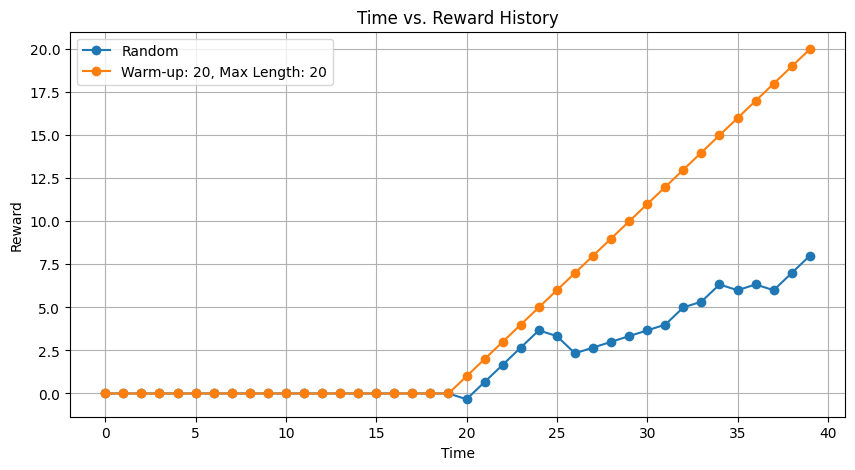

In [15]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 5))

# Calculate the average reward history for random rows
random_rows = results[results['random']]
if len(random_rows) > 0:
    avg_reward_history = random_rows['reward_history'].apply(pd.Series).mean().tolist()
    plt.plot(results['time_history'].iloc[0], avg_reward_history, marker='o', linestyle='-', label='Random')

# # Calculate the average reward history for non-random rows with the same warm-up and max_length
non_random_rows = results[~results['random']]

if len(non_random_rows) > 0:
    avg_reward_history = non_random_rows.groupby(['warm_up', 'max_length'])['reward_history'].apply(
        lambda x: pd.DataFrame(x.tolist()).mean().tolist()
)
    for (warm_up, max_length), reward_history in avg_reward_history.items():
        label = f"Warm-up: {warm_up}, Max Length: {max_length}"
        plt.plot(results['time_history'].iloc[0], reward_history, marker='o', linestyle='-', label=label)

plt.title('Time vs. Reward History')
plt.xlabel('Time')
plt.ylabel('Reward')
plt.grid(True)
plt.legend()
plt.show()